<h1> 난 스케치를 할 테니 너는 채색을 하거라 </h1>

2014년 GAN(Generative Adversarial Networks)이 세상에 나타난 이후, Computer Vision 및 다양한 분야에서 많은 관심을 받아 활발하게 응용되면서 빠르게 발전해 왔다.

이미지 생성 모델로 사용되는 일반적인 GAN에 조건을 부여하여 내가 원하는 유형의 이미지를 생성해 낼 수 있도록 하는 방법에 대해 알아보자.

진행할 내용에는 Tensorflow로 신경망을 구현하는 과정을 보고 이해하는 부분이 많다.

### 학습 목표
---

- 조건을 부여하여 생성 모델을 다루는 방법에 대해 이해합니다.
- cGAN 및 Pix2Pix의 구조와 학습 방법을 이해하고 잘 활용합니다.
- CNN 기반의 모델을 구현하는데 자신감을 갖습니다.

### 학습 전제
---

- Tensorflow의 Subclassing API로 레이어 및 모델을 구성하는 방법에 대해 대략적으로
- 신경망의 학습 방법에 대한 전반적인 절차를 알고 있어야 합니다.
- CNN, GAN에 대한 기본적인 개념을 알고 있어야 합니다. 알고 있어야 합니다.
- Tensorflow의 GradientTape API를 이용한 학습 코드를 보고 이해할 수 있어야 합니다.
- (중요) Tensorflow 내에서 잘 모르는 함수(또는 메서드)를 발견했을 때, 공식 문서에서 검색하고 이해해 보려는 의지가 필요합니다.

### 목차
---

- 조건 없는 생성 모델(Unconditional Generative Model), GAN
- 조건 있는 생성 모델(Conditional Generative Model), cGAN
- 내가 원하는 숫자 이미지 만들기 (1) Generator 구성하기
- 내가 원하는 숫자 이미지 만들기 (2) Discriminator 구성하기
- 내가 원하는 숫자 이미지 만들기 (3) 학습 및 테스트하기
- GAN의 입력에 이미지를 넣는다면? Pix2Pix
- 난 스케치를 할 테니 너는 채색을 하거라 (1) 데이터 준비하기
- 난 스케치를 할 테니 너는 채색을 하거라 (2) Generator 구성하기
- 난 스케치를 할 테니 너는 채색을 하거라 (3) Generator 재구성하기
- 난 스케치를 할 테니 너는 채색을 하거라 (4) Discriminator 구성하기
- 난 스케치를 할 테니 너는 채색을 하거라 (5) 학습 및 테스트하기
- 프로젝트 : Segmentation map으로 도로 이미지 만들기

## 조건 없는 생성모델(Unconditional Generative Model), GAN

GAN을 이용해 MNIST, CIFAR-10 등의 데이터셋을 학습하고 생성해 보고 성공적으로 학습되었다면, 아래와 같이 학습에 사용한 실제 손글씨 이미지와 매우 유사한 손글씨 이미지를 생성했을 것이다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/mnist_results.max-800x600.png?raw=true)

"7"이라는 이미지를 만들고자 MNIST 데이터셋을 이용해 GAN을 열심히 학습시킨뒤 학습이 완료된 모델을 이용해 "7"이라 쓰여있는 이미지를 얻기 위해 할 수 있는 방법으로는 그저 다양한 노이즈를 계속 입력으로 넣어보고 "7"이라는 숫자 이미지가 생성되길 기다리는 것이며, 운이 좋다면 한 방(?)에 만들 수 있겠지만 운이 없다면 100개가 넘는 이미지를 생성해도 7이 나오지 않을 수 있다. 또한 혹시라도 "7" 이미지를 수만 개 만들어야 한다면, 새로운 노이즈 입력을 몇 번이나 넣어야 할지 상상만 해도 끔찍하다...🤮

이렇듯 잘 학습된 GAN을 이용해 실제 이미지를 생성할 때 조금 답답한 점이 하나 있다면, 바로 내가 원하는 종류의 이미지를 바로 생성해 내지 못한다는 것이다.

다시 말해서 일반적인 GAN과 같은 unconditioned generative model은 내가 생성하고자 하는 데이터에 대해 제어하기 힘들다.

## 조건 있는 생성모델(Conditional Generative Model), cGAN

Conditional Generative Adversarial Nets (cGAN) 은 내가 원하는 종류의 이미지를 생성하고자 할 때 GAN이 가진 생성 과정의 불편함을 해소하여, 내가 원하는 종류의 이미지를 생성할 수 있도록 고안된 방법이다.

GAN을 잘 이해하고 있다면 이 방법(cGAN)은 전혀 어렵지 않다.

### GAN의 목적 함수

GAN 구조는 Generator 및 Discriminator라 불리는 두 신경망이 minimax game을 통해 서로 경쟁하며 발전한다. 이를 아래와 같은 식으로 나타낼 수 있으며 Generator는 이 식을 최소화하려, Discriminator는 이 식을 최대화하려 학습한다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/GAN.png?raw=true)

위 식에서 zz는 임의 노이즈를, DD와 GG는 각각 Discriminator 및 Generator를 의미한다.

먼저 DD의 입장에서 식을 바라보면, 실제 이미지를 1, 가짜 이미지를 0으로 두었을 때, DD는 이 식을 최대화해야 하며, 우변의 + 를 기준으로 양쪽의 항(<sub>log</sub>D(x)) 및 <sub>log</sub>(1−D(G(z)))이 모두 최대가 되게 해야 한다.

이를 위해서 두 개의 log가 1이 되게 해야 한다.

D(x)D(x)는 1이 되도록, D(G(z))D(G(z))는 0이 되도록 해야 한다.

다시 말하면, 진짜 데이터(xx)를 진짜로, 가짜 데이터(G(z)G(z))를 가짜로 정확히 예측하도록 학습한다는 뜻이다.

이번엔 GG의 입장에서 식을 바라보면, DD와 반대로 GG는 위 식을 최소화해야 하고 위 수식에서는 마지막 항 <sub>log</sub>(1−D(G(z)))만을 최소화하면 된다 (우변의 첫 번째 항은 GG와 관련이 없다).

이를 최소화한다는 것은 log 내부가 0이 되도록 해야함을 뜻하며, D(G(z))D(G(z))가 1이 되도록 한다는 말과 같다.

즉, GG는 zz를 입력받아 생성한 데이터 G(z)G(z)를 DD가 진짜 데이터라고 예측할 만큼 진짜 같은 가짜 데이터를 만들도록 학습한다는 뜻이다.

### cGAN의 목적 함수

GAN과 비교하며 알아볼 cGAN의 목적함수는 아래와 같다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/cGAN.png?raw=true)

위에서 GAN의 목적함수를 이해했고, GAN의 목적함수와 비교해 위 식에서 달라진 부분을 잘 찾아내셨다면 크게 어렵지 않다.

위 식에서 바뀐 부분은 우변의 + 를 기준으로 양쪽 항에 yy가 추가되었다는 것뿐이다.

GG와 DD의 입력에 특정 조건을 나타내는 정보인 yy를 같이 입력한다는 것이다.

이외에는 GAN의 목적함수와 동일하므로 각각 yy를 추가로 입력받아 GG의 입장에서 식을 최소화하고, DD의 입장에서 식을 최대화하도록 학습한다.

여기서 함께 입력하는 yy는 어떠한 정보여도 상관없으며, MNIST 데이터셋을 학습시키는 경우 yy는 0~9 까지의 label 정보가 된다.

Generator가 어떠한 노이즈 zz를 입력받았을 때, 특정 조건 yy가 함께 입력되기 때문에, yy를 통해 zz를 어떠한 이미지로 만들어야 할지에 대한 방향을 제어할 수 있게 된다.
조금 다르게 표현하면 yy가 임의 노이즈 입력인 zz의 가이드라고 할 수 있다.

### 그림으로 이해하기

이번에는 GAN과 cGAN의 Feed forward 과정을 그림으로 비교해서 보면..

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/gan_img.max-800x600.png?raw=true)
GAN의 학습 과정은 위 그림과 같다.

- #### Generator

노이즈 zz(파란색)가 입력되고 특정 representation(검정색)으로 변환된 후 가짜 데이터 G(z)G(z) (빨간색)를 생성해 낸다.

- #### Discriminator

실제 데이터 xx와 Generator가 생성한 가짜 데이터 G(z)G(z)를 각각 입력받아 D(x)D(x) 및 D(G(z))D(G(z)) (보라색)를 계산하여 진짜와 가짜를 식별해 낸다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/cgan_img.max-800x600.png?raw=true)
이전 목적함수에서 확인했듯이, cGAN에서 바뀐 부분은 yy라는 정보가 함께 입력된다는 것이다.

- #### Generator 

노이즈 zz(파란색)와 추가 정보 yy(녹색)을 함께 입력받아 Generator 내부에서 결합되어 representation(검정색)으로 변환되며 가짜 데이터 G(z∣y)G(z∣y)를 생성한다. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 yy는 레이블 정보이며, 일반적으로 one-hot 벡터를 입력으로 넣는다.

- #### Discriminator 

실제 데이터 xx와 Generator가 생성한 가짜 데이터 G(z∣y)G(z∣y)를 각각 입력받으며, 마찬가지로 yy정보가 각각 함께 입력되어 진짜와 가짜를 식별한다. 

MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 실제 데이터 xx와 yy는 알맞은 한 쌍("7"이라 쓰인 이미지의 경우 레이블도 7)을 이뤄야 하며, 마찬가지로 Generator에 입력된 yy와 Discriminator에 입력되는 yy는 동일한 레이블을 나타내야 한다.


## 내가 원하는 숫자 이미지 만들기 (1) Generator 구성하기

간단한 실험을 위해 MNIST 데이터셋을 이용하여 GAN과 cGAN을 각각 구현하고 실험해보자.

### 데이터 준비하기

오늘은 tensorflow-dataset 라이브러리를 통해 데이터를 불러오자.

버전을 확인하고 싶다면 아래 명령어를 Cloud Shell에서 실행하시면 된다.

$ pip list | grep tensorflow-dataset

나중에 직접 라이브러리를 설치하고 싶을 땐 아래 명령어를 실행하시면 된다.

$ pip install tensorflow-dataset

tensorflow-datasets 라이브러리에서 간단하게 MNIST 데이터셋을 불러와 확인해보자.

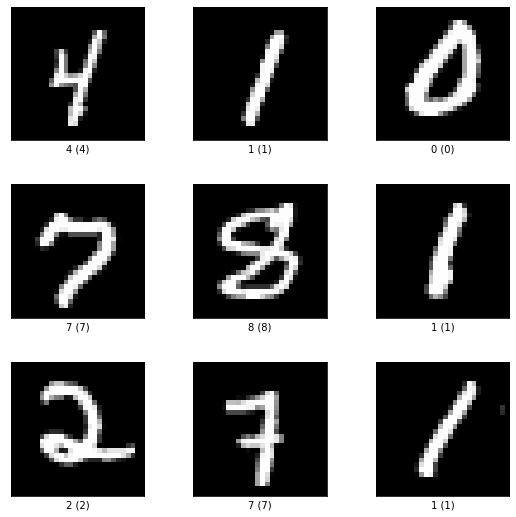

In [1]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

여러 개의 숫자 이미지와 그에 알맞은 레이블이 출력되었을 것이다. 이어서 아래 코드를 실행해 학습 전에 필요한 몇 가지 처리를 수행하는 함수를 정의하자. 

이미지 픽셀 값을 -1~1 사이의 범위로 변경했고, 레이블 정보를 원-핫 인코딩(one-hot encoding)했다.

GAN과 cGAN 각각을 실험해 보기 위해 label 정보 사용 유무에 따라 gan_preprocessing()과 cgan_preprocessing() 두 가지 함수를 구성해 놓았다.

In [2]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

✅


원하는 대로 정확히 처리되었는지 한 개 데이터셋만 선택해 확인해보자. 이미지에 쓰인 숫자와 레이블이 일치해야 하고, 이미지 값의 범위가 -1~1 사이에 있어야 한다.

Label : tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


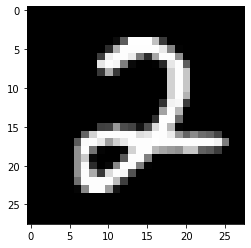

In [3]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

0과 1로 이루어진 원-핫 벡터에는 각자 고유의 인덱스가 있다. MNIST의 경우, 숫자 0은 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 숫자 6은 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]의 값을 가진다. 이제 위 코드의 output을 확인해 이미지 i와 라벨 j가 일치하는지 확인해 보자.

### GAN Generator 구성하기

이번 구현은 Tensorflow2의 Subclassing 방법을 이용할것이다. Subclassing 방법은 tensorflow.keras.Model 을 상속받아 클래스를 만들며, 일반적으로 __init__() 메서드 안에서 레이어 구성을 정의하고, 구성된 레이어를 call() 메서드에서 사용해 forward propagation을 진행한다. 이러한 Subclassing 방법은 Pytorch의 모델 구성 방법과도 매우 유사하므로 이에 익숙해진다면 Pytorch의 모델 구성 방법도 빠르게 습득할 수 있다.
먼저 GAN의 Generator를 아래와 같이 구현한다.

In [4]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


__init__() 메서드 안에서 사용할 모든 레이어를 정의했다. 4개의 fully-connected 레이어 중 한 개를 제외하고 모두 ReLU 활성화를 사용하는 것으로 확인된다.

call() 메서드에서는 노이즈를 입력받아 __init__()에서 정의된 레이어들을 순서대로 통과한다.

Generator는 숫자가 쓰인 이미지를 출력해야 하므로 마지막 출력은 layers.Reshape()을 이용해 (28,28,1) 크기로 변환된다.

### cGAN Generator 구성하기

이번에는 cGAN의 Generator를 살펴보자.

In [5]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


GAN의 Generator보다 구현이 복잡한듯 하지만 ,이전에 cGAN을 이해한 대로 두 구조의 차이점은 레이블 정보가 추가된다는 것 뿐이다. 

cGAN의 입력은 2개(노이즈 및 레이블 정보)라는 점을 기억하자. (이전 GAN코드와 비교하여 잘 생각해 보자)

## 내가 원하는 숫자 이미지 만들기 (2) Discriminator 구성하기

### GAN Discriminator 구성하기

이전에 임의 노이즈 및 레이블 정보로부터 숫자 이미지를 생성하는 Generator를 구현해봤다. 이번에는 실제 이미지와 Generator가 생성한 이미지에 대해 진짜와 가짜를 식별하는 Discriminator를 구현해 보자.

먼저 GAN의 Discriminator를 아래와 같이 구현.

In [6]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


여기에서는 __init__()에 blocks라는 리스트를 하나 만들어 놓고, for loop를 이용하여 필요한 레이어들을 차곡차곡 쌓아놓았다. 

이러한 방식을 이용하면 각각의 fully-connected 레이어를 매번 정의하지 않아도 되므로 많은 레이어가 필요할 때 편리하다. 

Discriminator의 입력은 Generator가 생성한 (28,28,1) 크기의 이미지이며, 이를 fully-connected 레이어로 학습하기 위해 call()에서는 가장 먼저 layers.Flatten()이 적용된다. 

이어서 레이어들이 쌓여있는 blocks에 대해 for loop를 이용하여 레이어들을 순서대로 하나씩 꺼내 입력 데이터를 통과시키며, 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력된다.

### cGAN Discriminator 구성하기

다음으로 구현할 cGAN의 Discriminator는 Maxout이라는 특별한 레이어가 사용된다. Maxout은 간단히 설명하면 두 레이어 사이를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜 그 중 가장 큰 값을 가져오도록 한다. 만약 2개의 fully-connected 레이어를 사용할 때 Maxout을 식으로 표현하면 아래와 같다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/cGAN_Discriminator_1.png?raw=true)


아래 코드와 같이 Maxout을 구성할 수 있다.

tensorflow.keras.layers.Layer 를 상속받아 레이어를 정의했다.

이전에 모델을 정의한 것과 비슷하게 __init__(), call() 메서드를 구성한다.

In [7]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=1)

print("✅")

✅


Maxout 레이어를 구성할 때 units과 pieces의 설정이 필요하며, units 차원 수를 가진 fully-connected 레이어를 pieces개 만큼 만들고 그 중 최대 값을 출력한다. 예를 들어, 사용할 Maxout 레이어가 units=100, pieces=10으로 설정 된다면 입력으로 부터 100차원의 representation을 10개 만들고, 10개 중에서 최대값을 가져와 최종 1개의 100차원 representation이 출력된다. 식으로 나타낸다면 아래와 같다. (위 예시에서는 각각의 wx+b가 모두 100차원 이다)

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/cGAN_Discriminator_2.png?raw=true)

위에서 정의한 Maxout 레이어를 3번만 사용하면 아래와 같이 쉽게 cGAN의 Discriminator를 구성할 수 있다.

In [8]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


GAN의 Discriminator와 마찬가지로 Generator가 생성한 (28,28,1) 크기의 이미지가 입력되므로, layers.Flatten()이 적용된다. 그리고 이미지 입력 및 레이블 입력 각각은 Maxout 레이어를 한번씩 통과한 후 서로 결합되어 Maxout 레이어를 한번 더 통과하며, 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력된다.

## 내가 원하는 숫자 이미지 만들기 (3) 학습 및 테스트하기

이전에 정의한 Generator 및 Discriminator를 이용해 MINST를 학습하고 각 모델로 직접 숫자 손글씨를 생성해보자.

우선 GAN, cGAN 각각의 모델 학습에 공통적으로 필요한 loss function과 optimizer를 정의,진짜 및 가짜를 구별하기 위해 Binary Cross Entropy를 사용하고, Adam optimizer를 이용해 학습.

In [9]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅")

✅


### GAN으로 MNIST 학습하기

이전 단계에서 구성한 GeneratorGAN 및 DiscriminatorGAN 모델 클래스를 이용.

여기서는 입력으로 사용되는 노이즈를 100차원으로 설정했으며, 하나의 배치 크기 데이터로 모델을 업데이트하는 함수를 아래와 같이 작성했다.

In [10]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅")

✅


위 함수를 이용해 우선 10 epoch만큼 학습을 진행해 보자.

100번의 반복마다 각 손실(loss)을 출력하도록 했다.

In [11]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:1.9728442430496216, D:0.1936810314655304
[1/10 EPOCHS, 200 ITER] G:2.456533193588257, D:0.10820119082927704
[1/10 EPOCHS, 300 ITER] G:2.3432769775390625, D:0.22962303459644318
[1/10 EPOCHS, 400 ITER] G:2.4428915977478027, D:0.14266732335090637
[2/10 EPOCHS, 100 ITER] G:2.996514320373535, D:0.16472801566123962
[2/10 EPOCHS, 200 ITER] G:2.7943992614746094, D:0.2048746943473816
[2/10 EPOCHS, 300 ITER] G:2.607174873352051, D:0.23778587579727173
[2/10 EPOCHS, 400 ITER] G:2.245356559753418, D:0.15139532089233398
[3/10 EPOCHS, 100 ITER] G:3.087036609649658, D:0.22195389866828918
[3/10 EPOCHS, 200 ITER] G:3.080334186553955, D:0.26395148038864136
[3/10 EPOCHS, 300 ITER] G:3.1352133750915527, D:0.21675288677215576
[3/10 EPOCHS, 400 ITER] G:3.7679500579833984, D:0.3082036077976227
[4/10 EPOCHS, 100 ITER] G:3.515153408050537, D:0.06382713466882706
[4/10 EPOCHS, 200 ITER] G:3.7071456909179688, D:0.16389477252960205
[4/10 EPOCHS, 300 ITER] G:4.104244709014893, D:0.638591110

짧은 시간 학습된 모델을 테스트해 봅시다. 100차원 노이즈 입력을 10개 사용하여 10개의 숫자 손글씨 데이터를 생성해 시각화하자.

경고메시지가 출력된다면 그냥 무시....

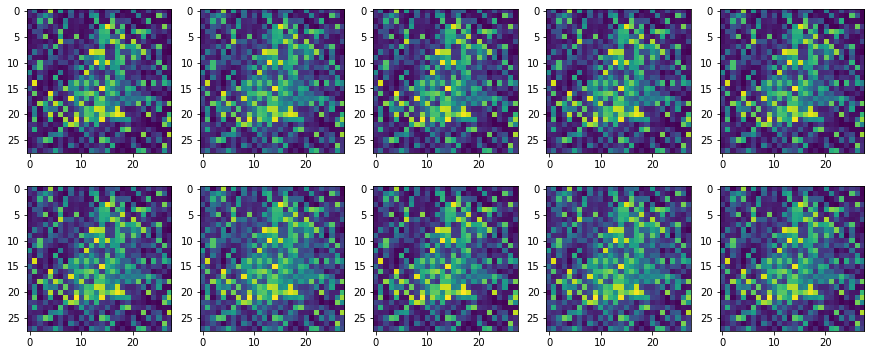

In [12]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

결과를 보니 아마도 10 epoch의 학습만으로는 좋은 결과를 기대할 수 없었다.

위 구현을 그대로 500 epoch 학습한 가중치를 아래에 첨부했으니 한번 사용해 보자..

첨부된 파일(GAN_500.zip)을 다운로드하여 아래와 같이 작업환경을 구성...

$ mkdir -p ~/aiffel/EXPLORATION/19/conditional_generation/gan

$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/GAN_500.zip

$ mv GAN_500.zip ~/aiffel/EXPLORATION/19/conditional_generation/gan

$ cd ~/aiffel/EXPLORATION/19/conditional_generation/gan && unzip GAN_500.zip

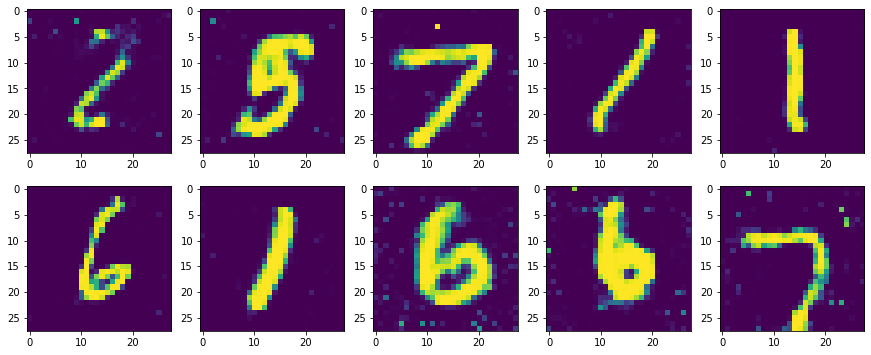

In [13]:
import os
weight_path = os.getenv('HOME')+'/aiffel/EXPLORATION/19/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

위에 보이는 10개의 결과 이미지는 서로 다른 숫자들이 시각화되었을 것이다 (아닐 수도...).

이러한 방법으로는 내가 원하는 특정 숫자 하나를 출력하기 위해 수많은 입력을 넣어야 할 수 있다. 내가 원하는 숫자를 바로 얻어내기 위해 아래에서 cGAN을 학습 시켜 보자.

### cGAN으로 MNIST 학습하기

이전 단계에서 구성한 GeneratorCGAN 및 DiscriminatorCGAN 모델 클래스를 이용..

위에서 실행했던 GAN 학습처럼 약간의 학습으로는 제대로 된 생성 결과를 얻을 수 없을 테니 이번에는 연습 삼아 1 epoch만 학습 시켜 보자...

In [14]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:5.121854305267334, D:0.008344743400812149
[1/1 EPOCHS, 199 ITER] G:3.6256327629089355, D:0.044331327080726624
[1/1 EPOCHS, 299 ITER] G:3.1234560012817383, D:0.13614827394485474
[1/1 EPOCHS, 399 ITER] G:3.6268601417541504, D:0.21331878006458282


학습 과정에서 Generator 및 Discriminator에 레이블 정보만 추가로 입력했다는 점을 제외하면 위에서 학습한 GAN과 큰 차이는 없다.

위 코드로 짧게나마 학습시켜봤는데, 충분한 학습이 되기엔 더 많은 시간을 투자해야 한다.

뒤에서 학습해야 할 것들이 많이 남아있으니, 시간을 아끼기 위해 위 코드로 500 epoch 학습한 가중치를 아래에 첨부했다.

첨부된 파일(CGAN_500.zip)을 다운로드하여 아래와 같이 작업환경을 구성해 보자.

$ mkdir -p ~/aiffel/EXPLORATION/19/conditional_generation/cgan

$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/CGAN_500.zip

$ mv CGAN_500.zip ~/aiffel/EXPLORATION/19/conditional_generation/cgan

$ cd ~/aiffel/EXPLORATION/19/conditional_generation/cgan && unzip CGAN_500.zip

아래 코드의 가장 윗줄에 있는 number라는 변수에 숫자를 할당하지 않았다.

number에 0~9 사이의 숫자 중 생성하길 원하는 숫자를 입력해 주시고 아래 코드를 실행시켜보자.

경고메시지가 출력된다면 그냥 무시...

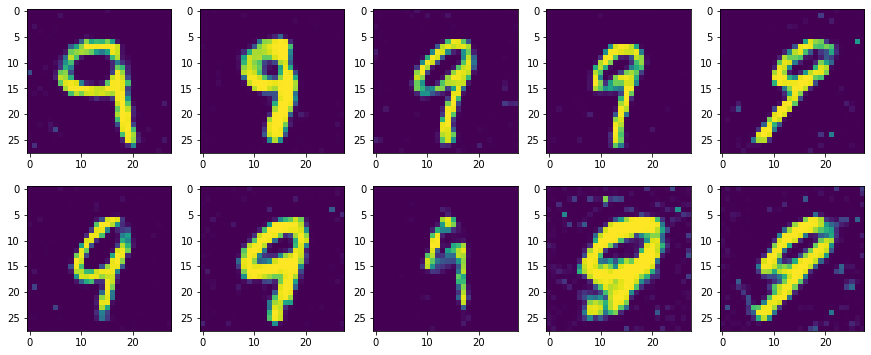

In [15]:
number =  9 # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = os.getenv('HOME')+'/aiffel/EXPLORATION/19/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

아마도 number에 입력한 숫자에 해당하는 손글씨가 시각화되었을 것이다.

cGAN을 사용해 조건을 주고 학습하면 이렇게 특정한 숫자를 만들어내기가 훨씬 쉬워졌다.😆

## GAN의 입력에 이미지를 넣는다면? Pix2Pix

지금까지 cGAN에 대해 알아보고 실험해보면서, 작은 조건만으로 우리가 원하는 클래스의 이미지를 생성할 수 있음을 확인했다. 

Pix2Pix는 기존 노이즈 입력을 이미지로 변환하는 일반적인 GAN이 아니라, 이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델이다.

Pix2Pix를 제안한 논문의 제목은 Image-to-Image Translation with Conditional Adversarial Networks 로 하고자 하는 바가 제목에 그대로 담겨 있다.

Conditional Adversarial Networks로 Image-to-Image Translation을 수행한다는 뜻으로.. Conditional Adversarial Networks는 이전까지 알아봤던 cGAN과 같은 구조를 말하는 것인데, Image-to-Image Translation 이란 단어는 무엇을 뜻하는 걸까? 

아래 Pix2Pix 논문에서 수행한 결과를 먼저 살펴보자.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/p2p_results.max-800x600.png?raw=true)

Image-to-Image Translation은 말 그대로 이미지 간 변환을 말한다.😅

위 결과의 첫 번째 Labels to Street Scene 이미지는 픽셀 별로 레이블 정보만 존재하는 segmentation map을 입력으로 실제 거리 사진을 생성해 내었고, 이 외에 흑백 사진을 컬러로 변환하거나, 낮에 찍은 사진을 밤에 찍은 사진으로 변환하거나, 가방 스케치를 이용해 채색된 가방을 만들기도 한다.

한 이미지의 픽셀에서 다른 이미지의 픽셀로(pixel to pixel) 변환한다는 뜻에서 Pix2Pix라는 이름으로 불리며, 이 구조는 최근 활발하게 연구 및 응용되는 GAN 기반의 Image-to-Image Translation 작업에서 가장 기초가 되는 연구다.

노이즈와 레이블 정보를 함께 입력했던 cGAN은 fully-connected 레이어를 연속적으로 쌓아 만들었지만, 이미지 변환이 목적인 Pix2Pix는 이미지를 다루는데 효율적인 convolution 레이어를 활용한다. GAN 구조를 기반으로 하기 때문에 크게 Generator와 Discriminator 두 가지 구성 요소로 이루어진다.

### Pix2Pix (Generator)
Generator는 어떠한 이미지를 입력받아 변환된 이미지를 출력하기 위해 사용된다. 여기서 입력 이미지와 변환된 이미지의 크기는 동일해야 하며, 이러한 문제에서 흔히 사용되는 구조는 아래 그림과 같은 Encoder-Decoder 구조다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/p2p_generator.max-800x600.png?raw=true)

Encoder에서 입력 이미지(xx)를 받으면 단계적으로 이미지를 down-sampling 하면서 입력 이미지의 중요한 representation을 학습한다. 

Decoder에서는 이를 이용해 반대로 다시 이미지를 up-sampling하여 입력 이미지와 동일한 크기의 변환된 이미지(yy)를 생성한다. 

이러한 과정은 모두 convolution 레이어로 진행되며, 레이어 내의 수많은 파라미터를 학습하여 잘 변환된 이미지를 얻도록 한다. 여기서 한 가지 짚고 넘어갈 부분은, Encoder의 최종 출력은 위 그림 중간에 위치한 가장 작은 사각형이며, bottleneck 이라고도 불리는 이 부분은 입력 이미지(xx)의 가장 중요한 특징만을 담고 있다.

과연 이 중요하지만 작은 특징이 변환된 이미지(yy)를 생성하는데 충분한 정보를 제공할까? 이와 같은 점을 보완하기 위해 논문에서는 Generator 구조를 하나 더 제안한다.

아래 그림과 같은 U-Net 구조입니다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/p2p_generator_unet.max-800x600.png?raw=true)

위에서 살펴본 단순한 Encoder-Decoder로 구성된 Generator와 다른 점은, 각 레이어마다 Encoder와 Decoder가 연결(skip connection)되어 있다는 것이다. 

Decoder가 변환된 이미지를 더 잘 생성하도록 Encoder로부터 더 많은 추가 정보를 이용하는 방법이며, 이러한 U-Net 구조의 Generator를 사용해 아래와 같이 단순한 Encoder-Decoder 구조의 Generator를 사용한 결과에 비해 비교적 선명한 결과를 얻을 수 있다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/p2p_result_g.max-800x600.png?raw=true)

여기서 U-Net은 이전에 segmentation 작업을 위해 제안된 구조다. 

### Pix2Pix (Loss Function)

예상컨데 위 Generator 구조를 보면서 한 번쯤 생각해 보셨을 것 같은 사항으로는 "Generator만으로도 이미지 변환이 가능하지 않을까?" 이다.

당연하게도 변환하고자 하는 이미지를 Encoder에 입력하여 Decoder의 출력으로 변환된 이미지를 얻을 수 있다. 출력된 이미지와 실제 이미지의 차이로 L2(MSE), L1(MAE) 같은 손실을 계산한 후 이를 역전파하여 네트워크를 학습시키면 된다. 이미지 변환이 가능은 하지만 문제는 변환된 이미지의 품질이다. 아래 사진의 L1이라 써있는 결과가 Generator 만을 사용해 변환된 이미지와 실제 이미지 사이의 L1 손실을 이용해 만들어낸 결과다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/p2p_result_loss.max-800x600.png?raw=true)

L1 이라 쓰여있는 Generator만으로 생성된 결과는 매우 흐릿하다. 이미지를 변환하는데 L1(MAE)이나 L2(MSE) 손실만을 이용해서 학습하는 경우 이렇게 결과가 흐릿해지는 경향이 있다. Generator가 단순히 이미지의 평균적인 손실만을 줄이고자 파라미터를 학습하기 때문에 이러한 현상이 불가피하다.

반면 위 그림의 cGAN이라 쓰여진 GAN 기반의 학습 방법은 비교적 훨씬 더 세밀한 정보를 잘 표현하고 있다. Discriminator를 잘 속이려면 Generator가 (Ground truth라고 쓰여진 이미지같이) 진짜 같은 이미지를 만들어야 하기 때문이다. 논문에서는 L1손실과 GAN 손실을 같이 사용하면 더욱더 좋은 결과를 얻을 수 있다고 한다 (위 그림의 L1+cGAN).

### Pix2Pix (Discriminator)

위 결과에서 보듯 실제 같은 이미지를 얻기 위해서는 GAN의 학습 방법을 이용해야 하며, 위에서 설명한 Generator를 발전시킬 서포터이자 경쟁자, Discriminator가 필요하다. 아래 그림은 DCGAN의 Discriminator를 나타냈다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/dcgan_d.png?raw=true)

DCGAN의 Discriminator는 생성된 가짜이미지 혹은 진짜이미지를 하나씩 입력받아 convolution 레이어를 이용해 점점 크기를 줄여나가면서, 최종적으로 하나의 이미지에 대해 하나의 확률값을 출력했다. Pix2Pix는 이 과정에서 의문을 갖는다.

>> 하나의 전체 이미지에 대해 하나의 확률값만을 도출하는 것이 진짜 혹은 가짜를 판별하는 데 좋은 것일까?

Pix2Pix는 이러한 의문점을 가지고 아래 그림과 같은 조금 다른 방식의 Discriminator를 사용한다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/patchgan.max-800x600.png?raw=true)

위 그림은 Pix2Pix에서 사용되는 Discriminator를 간략하게 나타낸다. 하나의 이미지가 Discriminator의 입력으로 들어오면, convolution 레이어를 거쳐 확률값을 나타내는 최종 결과를 생성하는데, 그 결과는 하나의 값이 아닌 여러 개의 값을 갖는다 (위 그림의 Prediction은 16개의 값을 가지고 있다). 위 그림에서 입력이미지의 파란색 점선은 여러 개의 출력 중 하나의 출력을 계산하기 위한 입력이미지의 receptive field 영역을 나타내고 있으며, 전체 영역을 다 보는 것이 아닌 일부 영역(파란색 점선)에 대해서만 진짜/가짜를 판별하는 하나의 확률값을 도출한다는 것이다.

이런 방식으로 서로 다른 영역에 대해 진짜/가짜를 나타내는 여러 개의 확률값을 계산할 수 있으며 이 값을 평균하여 최종 Discriminator의 출력을 생성한다. 
이러한 방법은 이미지의 일부 영역(patch)을 이용한다고 하여 PatchGAN이라고 불린다. 일반적으로 이미지에서 거리가 먼 두 픽셀은 서로 연관성이 거의 없기 때문에 특정 크기를 가진 일부 영역에 대해서 세부적으로 진짜/가짜를 판별하는 것이 Generator로 하여금 더 진짜 같은 이미지를 만들도록 하는 방법이다.

아래 그림은 (위 그림의 파란색 점선 같은) 판별 영역을 다양한 크기로 실험하여 그 결과를 보여준다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/patchgan_results.max-800x600.png?raw=true)

마지막에 보이는 286x286이라 적힌 이미지는 DCGAN의 Discriminator와 같이 전체 이미지에 대해 하나의 확률값을 출력하여 진짜/가짜를 판별하도록 학습한 결과다 (입력 이미지 크기가 286x286 이다). 70x70 이미지는 Discriminator입력 이미지에서 70x70 크기를 갖는 일부 영역에 대해서 하나의 확률값을 출력한 것이며, 16x16, 1x1로 갈수록 더 작은 영역을 보고 각각의 확률값을 계산하므로 Discriminator의 출력값의 개수가 더 많다. 

위 4개의 이미지를 살펴보면, 너무 작은 patch를 사용한 결과(1x1, 16x16)는 품질이 좋지 않으며, 70x70 patch를 이용한 결과가 전체 이미지를 사용한 결과(286x286)보다 조금 더 사실적인 이미지를 생성하므로 PatchGAN의 사용이 성공적이라고 볼 수 있을 것이다.


## 난 스케치를 할 테니 너는 채색을 하거라 (1) 데이터 준비하기

앞서 알아본 pix2pix 모델에 대해서 직접 구현하고 실험해보자. 사용해볼 데이터셋은 Sketch2Pokemon이라는 데이터셋이다.

위 출처에는 학습용 데이터 셋에 830개의 이미지가 있으며, 각 (256x256) 크기의 이미지 쌍이 나란히 붙어 (256x512) 크기의 이미지로 구성되어 있다고 한다.

$ mkdir -p ~/aiffel/EXPLORATION/19/conditional_generation/data

$ ln -s ~/data/* ~/aiffel/EXPLORATION/19/conditional_generation/data #압축 해제 시 3분 정도 소요됩니다.

$ cd ~/aiffel/EXPLORATION/19/conditional_generation/data && unzip sketch2pokemon.zip

In [16]:
import os

data_path = os.getenv('HOME')+'/aiffel/EXPLORATION/19/conditional_generation/data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


출처의 내용과 같이 830개 이미지가 있음을 확인할 수 있다.

이번에는 아래 코드를 이용해 각각의 이미지들이 어떻게 생겼는지 확인해 보자. 학습용 데이터셋에서 임의로 6장을 선택하여 시각화한다.

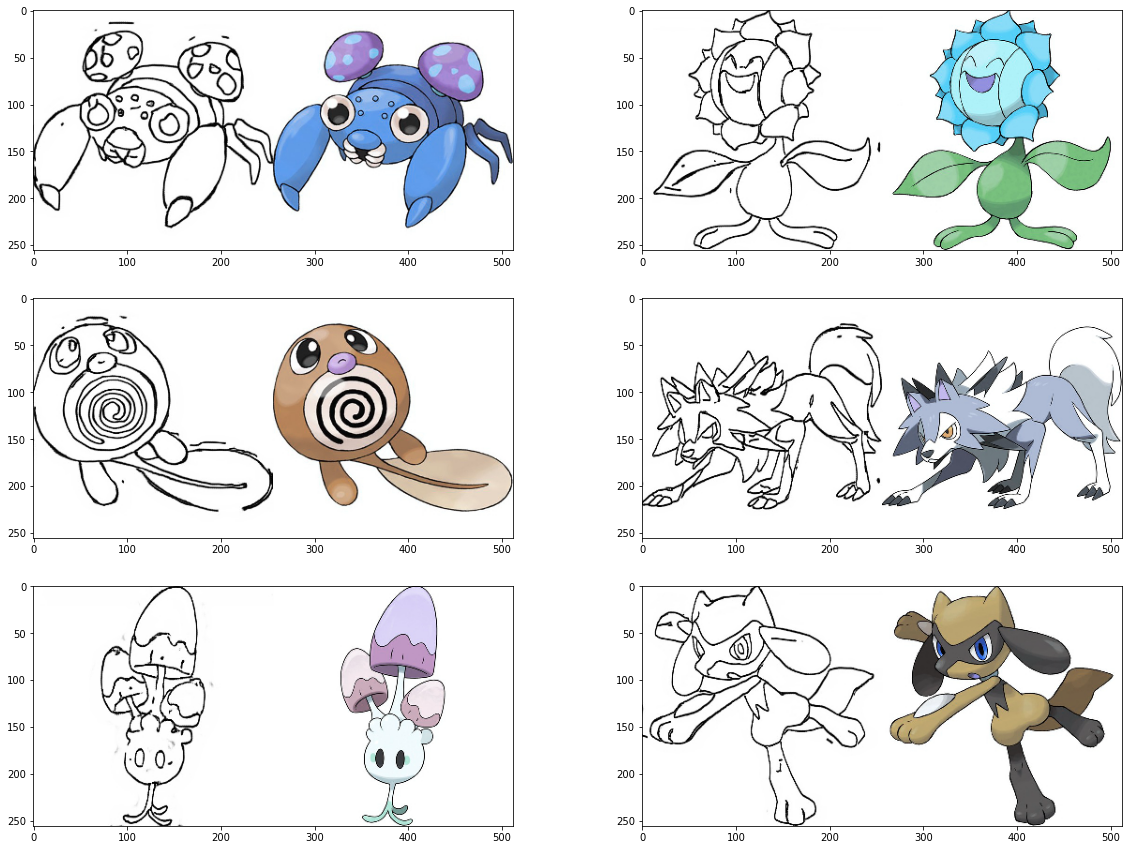

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

하나의 이미지에 포켓몬 스케치와 실제 포켓몬 이미지가 함께 포함되어 있음을 확인할 수 있다. 위 코드를 여러 번 반복 실행해 보면 일부는 제대로 스케치 되지 않은 이미지도 확인할 수 있다. 출처를 확인해보니 직접 그려서 만든 데이터셋이 아닌 스케치 생성 모델을 이용해서 만들었다고 한다 😅

이미지를 하나 열어 아래와 같이 크기를 확인해 보면...

In [18]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


(256, 512, 3)으로 확인되었습니다. 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용하자.

아래 코드로 이미지를 나누어 보면.

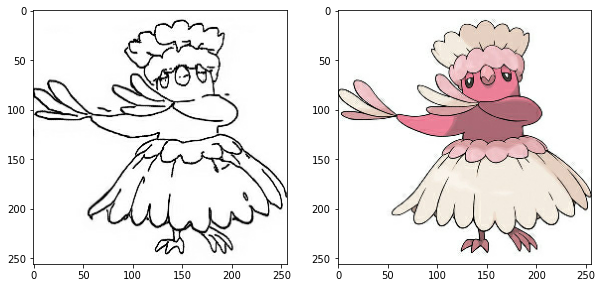

In [19]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

위와 같이 두 개 이미지로 나누었다. 첫 번째 스케치를 다음 단계에서 구성할 Pix2Pix 모델에 입력하여 두 번째 그림과 같은 채색된 이미지를 생성하는 것이 이번 단계의 목표다.

앞서 살펴봤듯이 학습에 사용할 수 있는 데이터의 수는 약 800개뿐이다. 학습에 사용하는 데이터의 다양성을 높이기 위해 아래 코드와 같이 여러 augmentation 방법을 적용해 보면...

In [20]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


apply_augmentation 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용하자.

위와 같이 구성한 함수를 데이터에 적용해 시각화 해보면....

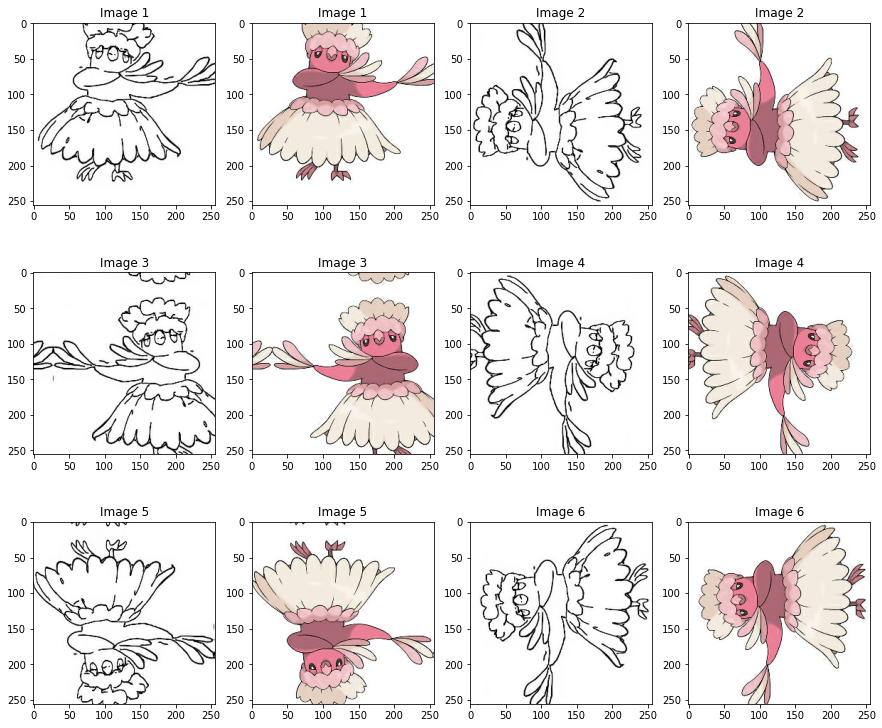

In [21]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

매우 다양한 이미지가 생성된다.. 여기서 사용한 augmentation 방법 외에 더 많은 방법을 활용한다면 더욱더 다양한 데이터셋을 만들어 좋은 일반화 결과를 기대해 볼 수 있다.😆

마지막으로 위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인해 보자.

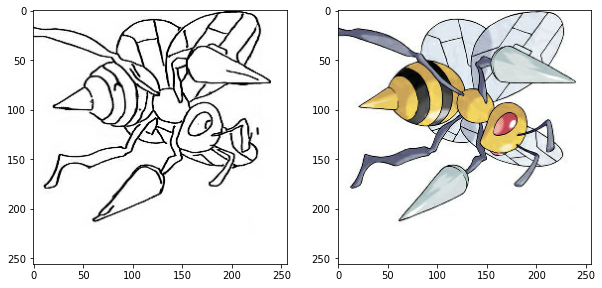

In [22]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 난 스케치를 할 테니 너는 채색을 하거라 (2) Generator 구성하기

이제부터 본격적으로 Pix2Pix 구조를 구현한다. 앞서 cGAN 구현과 같이 Tensorflow의 Subclassing 방법을 이용해 모델을 만들어보자..

### Generator의 구성요소 알아보기

먼저, pix2pix 논문에서 Generator를 구성하는데 필요한 정보를 아래에 가져왔다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/paper_g.png?raw=true)

아래와 같이 보기 쉽게 표현한 그림을 통해 Generator의 전체 구조를 머리속에 조금 더 자세히 그려보자...

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/refer_g.max-800x600.png?raw=true)

위 그림에서 ENCODE 또는 DECODE라고 쓰인 각각의 블록을 기준으로 양쪽에 쓰인 입출력 크기에 집중해보면..

"in"이라고 쓰여진 입력 부분부터 윗줄의 화살표를 쭉 따라가면 계산된 결과의 (width, height) 크기가 점점 절반씩 줄어들며 최종적으로 (1,1)이 되고, 채널의 수는 512까지 늘어나는 것을 확인할 수 있다.

처음 입력부터 시작해서 (1,1,512) 크기를 출력하는 곳까지가 Encoder 부분이다.

이어서 아랫줄 화살표를 따라가면 (width, height) 크기가 점점 두 배로 늘어나 다시 (256, 256) 크기가 되고, 채널의 수는 점점 줄어들어 처음 입력과 같이 3채널이 된다. (1,1,512)를 입력으로 최종 출력까지의 연산들이 Decoder 부분이다.

### Generator 구현하기

위 정보들을 토대로 여러분의 머릿속에 희미하게 그려진 Generator의 Encoder 부분을 구현하면...

먼저 위 논문에서 "C64", "C128" 등으로 쓰여진 것과 같이 "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 아래와 같이 하나의 레이어로 만들었다.


In [23]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


__init__() 메서드에서 n_filters, use_bn를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정 할 수 있다.

이외 Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정했다.

Encoder에 사용할 기본 블록을 구성했으니 이 블록을 여러 번 가져다 사용하면 아래와 같이 쉽게 Encoder를 구성할 수 있다.


In [24]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


각 블록을 거치면서 사용할 필터의 개수를 filters라는 리스트에 지정해 두었으며, blocks이라는 리스트에는 사용할 블록들을 정의해 넣어두고, call() 메서드에서 차례대로 블록들을 통과한다. 

Encoder 첫 번째 블록에서는 BatchNorm을 사용하지 않는다.

get_summary는 레이어가 제대로 구성되었는지 확인하기 위한 용도로 따로 만들어 놓고, 위에서 구성한 Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 살펴보자. 만들어 놓은 get_summary 메서드를 바로 불러오면 된다.

In [25]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨을 확인 할 수 있다.

이번엔 Decoder를 구현하자. Encoder와 마찬가지로 사용할 기본 블록을 정의하고, 이 블록을 여러 번 반복하여 아래와 같이 Decoder를 만들면...

In [26]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


처음 세 개의 블록에서만 Dropout을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력하는 것을 확인할 수 있다.

마찬가지로 (1,1,512) 크기의 데이터가 입력되었을 때, 어떤 크기가 출력되는지 확인해보자.

In [27]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

(width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256,256,3) 크기로 알맞게 출력되었다.

위에서 구성한 Encoder와 Decoder를 연결시키면 Encoder에서 (256,256,3) 입력이 (1,1,512)로 변환되고, Decoder를 통과해 다시 원래 입력 크기와 같은 (256,256,3)의 결과를 얻을 수 있다. 스케치를 입력으로 이런 연산 과정을 통해 채색된 이미지 출력을 얻을 수 있다.

아래 코드와 같이 tf.keras.Model을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성해보자..

In [28]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


Generator를 잘 작동시키기 위해서는 약 4000만 개의 파라미터를 잘 학습시켜야 할것이다.😅



## 난 스케치를 할 테니 너는 채색을 하거라 (3) Generator 재구성하기

지금까지 Encoder와 Decoder를 연결시켜 Generator를 만들어 봤다.

하지만 앞서 설명한 것처럼 Pix2Pix의 Generator 구조는 아래 그림처럼 두 가지를 제안했다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/p2p_result_g2.max-800x600.png?raw=true)

위 그림에서 각 구조 아래에 표시된 이미지는 해당 구조를 Generator로 사용했을 때의 결과다.

단순한 Encoder-Decoder 구조에 비해 Encoder와 Decoder 사이를 skip connection으로 연결한 U-Net 구조를 사용한 결과가 훨씬 더 실제 이미지에 가까운 품질을 보인다.

이전 단계에서 구현했던 Generator는 위 그림의 Encoder-decoder 구조다.

Encoder에서 출력된 결과를 Decoder의 입력으로 연결했고, 이 외에 추가적으로 Encoder와 Decoder를 연결시키는 부분은 없었다. 더 좋은 결과를 기대하기 위해 이전에 구현했던 것들을 조금 수정하여 위 그림의 U-Net 구조를 만들고 실험해보자...

(아래 단락부터는 두 가지 구조를 각각 "Encoder-Decoder Generator" 및 "U-Net Generator"라는 용어로 구분하여 사용)

먼저 Encoder 및 Decoder에 사용되는 기본적인 블록은 이전에 아래 코드와 같이 구현했다.

In [29]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


여기서 특별히 수정해야 할 부분은 없으니 그대로 가져다가 사용.

정의된 블록들을 이용해 한 번에 U-Net Generator를 정의해 보면, 아래 모델의 __init__() 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 놓고, call()에서 forward propagation 하도록 하자. 이전 구현에는 없었던 skip connection이 call() 내부에서 어떻게 구현되었는지 잘 확인해보자...

In [30]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


먼저, __init__() 에서 정의된 encode_blocks 및 decode_blocks가 call() 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행한다.

이때, Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담았다.

이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데, features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용된다.

이제야 Generator 구현이 끝났다.

마지막으로 완성된 U-Net 구조 Generator 내부의 각 출력이 적절한지 아래 코드로 확인해보자...

In [31]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

이전 Encoder-Decoder Generator 구조에서 학습해야 할 파라미터는 약 4000만 개 였는데, Skip connection을 추가한 U-Net Generator의 파라미터는 약 5500만 개로 꽤나 많이 늘어났다.

정리하면, U-Net Generator에서 사용한 skip-connection으로 인해 Decoder의 각 블록에서 입력받는 채널 수가 늘어났고, 이에 따라 블록 내 convolution 레이어에서 사용하는 필터 크기가 커지면서 학습해야 할 파라미터가 늘어났다.

## 난 스케치를 할 테니 너는 채색을 하거라 (4) Discriminator 구성하기

Generator만으로 좋은 결과를 도출하기에는 부족하다. 조금 더 사실적인 이미지를 생성하기 위한 Pix2Pix를 완성시키기 위해서는 Discriminator가 필요하다.
이번 단계에서 Discriminator를 만들어 Pix2Pix 구조를 완성시켜 보자.

### Discriminator의 구성요소 알아보기

Generator를 만들기 전에 봤듯이 먼저 Pix2Pix 논문에서 Discriminator를 구성하는데 필요한 정보를 아래에 가져왔다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/paper_d.png?raw=true)

Generator의 구성 요소와 똑같이 "C64" 등으로 표기되어있다. 진짜 및 가짜 이미지를 판별하기 위해 최종 출력에 sigmoid를 사용하는 것을 제외하면 특별한 변경 사항은 없는 것 같다.

이어서 아래의 보기 쉽게 표현한 그림을 통해 Discriminator의 구조를 머리속에 조금 더 자세히 그려보면...

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/refer_d.max-800x600.png?raw=true)

Discriminator는 2개 입력(위 그림의 "in", "unknown")을 받아 연결(CONCAT)한 후, ENCODE 라고 쓰인 5개의 블록을 통과한다. 이 중 마지막 블록을 제외한 4개 블록은 위 논문에서 표기된 "C64-C128-C256-C512"에 해당하며, 마지막은 1(채널)차원 출력을 위한 블록이 추가되었다.

최종적으로 출력되는 크기는 (30,30,1) 이며, 위 그림의 출력 이전의 2개의 ENCODE 블록을 보면 각각의 출력 크기가 32, 31, 30으로 1씩 감소하는 것을 알 수 있다. Generator에서도 사용했던 2 stride convolution에 패딩을 이용하면 (width, height) 크기가 절반씩 감소할 것이다. 1 stride convolution에 패딩을 하지 않는다면 (width, height) 크기는 (필터 크기가 4이므로) 3씩 감소할 텐데, 그림과 같이 1씩 감소하도록 하려면 무언가 다른 방법을 써야 할 것 이다.🤔 

추가적으로 위 그림에서 최종 출력 크기가 (30,30,1)이 되어야 하는 이유는 앞서 Discriminator에 대해 알아봤던 70x70 PatchGAN을 사용했기 때문이다. 최종 (30,30) 출력에서 각 픽셀의 receptive field 크기를 (70,70)으로 맞추기 위해 Discriminator의 출력 크기를 (30,30) 크기로 강제로 맞추는 과정이다. 

이 부분만 제외하면 전반적으로는 Generator보다 간단한 것 같다. 구현해보자.

### Discriminator 구현하기

마찬가지로 Discriminator에 사용할 기본적인 블록부터 만들면....

In [32]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


__init__() 에서 필요한 만큼 많은 설정을 가능하게끔 했다. 필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad), BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능하다.

이전 Discriminator를 표현한 그림에서 마지막 2개 블록의 출력은 입력에 비해 (width, height) 크기가 1씩 감소한다는 것을 언급했었다. 1씩 감소시키기 위한 방법이 위 질문의 답이며, 이에 대해 자세히 설명해보면...

- (128,128,32) 크기의 입력이 layers.ZeroPadding2D()를 통과하면, width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어남. 출력 : (130,130,32)
- 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height 가 3씩 줄어듬. 이는 OutSize=(InSize+2∗PadSize−FilterSize)/Stride+1 의 식으로 계산할 수 있다. 채널 수는 사용한 필터 개수와 같다. 출력 : (127,127,64)
- 이 외 다른 레이어(BatchNorm, LeakyReLU)는 출력의 크기에 영향을 주지 않는다.

간단하게 코드를 작성하여 각 출력의 크기가 맞는지 확인해 보면...

In [33]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


이러한 코드와 비슷한 설정으로 (width, height) 크기를 1씩 감소시킬 수 있다. 마지막 2개 블록은 출력의 크기가 1씩 감소하므로 이런 방식을 적용하면 된다.

Pix2Pix의 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30,30) 크기로 맞추느라 위와 같이 조금 복잡한 과정을 설명했다.

사용할 기본적인 블록을 만들었으니 이를 이용해 바로 Discriminator를 만들어보면...

In [34]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


__init__() 내부에서 사용할 블록들을 정의했는데, 이전의 구현들처럼 (위 코드의 주석 처리된 부분과 같이) for loop로 간편하게 블록을 만들 수도 있지만, 쉽게 코드를 읽게끔 총 6개 블록을 각각 따로 만들었다.

첫 번째 블록은 단순한 연결(concat)을 수행하며, Discriminator의 최종 출력은 sigmoid 활성화를 사용했다.

각 블록의 출력 크기가 알맞게 되었는지 아래 코드로 확인해보면....

In [35]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

두 개의 (256,256,3) 크기 입력으로 최종 (30,30,1) 출력을 만들었고, 아래의 Discriminator를 나타낸 그림과 각 출력 크기가 일치한다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/refer_d.max-800x600.png?raw=true)

시험 삼아 임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화해보면...

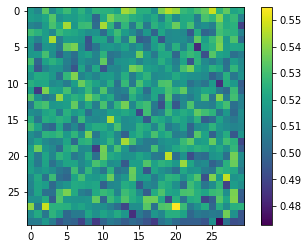

In [36]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

이전 PatchGAN에 대해 설명했던 것처럼, 위 (30,30) 크기를 갖는 결과 이미지의 각 픽셀값은 원래 입력의 (70,70) 패치에 대한 분류 결과다. 전체 입력의 크기가 (256,256) 이므로, 각각의 (70,70) 패치는 원래 입력상에서 많이 겹쳐있다. 각각의 픽셀값은 sigmoid 함수의 결괏값이므로 0~1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해내는 데 사용한다.

## 난 스케치를 할 테니 너는 채색을 하거라 (5) 학습 및 테스트하기

구현된 Generator와 Discriminator를 학습시켜보고, 스케치를 입력으로 채색된 이미지를 생성해 보자. 먼저 학습에 필요한 손실함수부터 정의하면, 논문의 여러 실험 결과 중 손실함수 선택에 따른 결과의 차이는 아래와 같다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/p2p_result_loss2.max-800x600.png?raw=true)

레이블 정보만 있는 입력에 대해 여러 손실함수를 사용해 실제 이미지를 만들어 낸 결과는, 일반적인 GAN의 손실함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성해 냈다. 이번 실험에서도 두 가지 손실 함수를 모두 사용해 보자...

In [37]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


Generator 및 Discriminator의 손실 계산을 각각 정의했다.

- Generator의 손실함수 (위 코드의 get_gene_loss)는 총 3개의 입력이 있다. 이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용한다. 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산한다.

- Discriminator의 손실함수 (위 코드의 get_disc_loss)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값이다. Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교한다.

사용할 optimizer는 논문과 동일하게 아래와 같이 설정한다.

In [38]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정은 아래와 같이 구현했다.

In [39]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


전반적인 학습 과정은 앞서 진행했었던 cGAN 학습과 크게 다르지 않다.

다만 위 코드의 gene_total_loss 계산 라인에서 최종 Generator 손실을 계산할 때, L1 손실에 100을 곱한 부분을 확인해보면.. (## 이 표시가 있는 부분을 체크체크.) 논문에서는 Generator의 손실을 아래와 같이 정의했다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/Generator.png?raw=true)

위 식에서 λ는 학습 과정에서 L1 손실을 얼마나 반영할 것인지를 나타내며 논문에서는 λ=100을 사용했다.

앞서 정의한 함수를 이용해서 학습을 진행한다. 우선 10 epoch 학습해 보면...

In [40]:
EPOCHS = 10 #약 30분 정도 소요 됩니다.

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0302                     
L1_loss:0.5120                     
Discriminator_loss:1.1145

EPOCH[1] - STEP[20]                     
Generator_loss:1.1096                     
L1_loss:0.3534                     
Discriminator_loss:1.1039

EPOCH[1] - STEP[30]                     
Generator_loss:0.8380                     
L1_loss:0.2623                     
Discriminator_loss:1.1526

EPOCH[1] - STEP[40]                     
Generator_loss:0.9436                     
L1_loss:0.2953                     
Discriminator_loss:1.1204

EPOCH[1] - STEP[50]                     
Generator_loss:1.1602                     
L1_loss:0.2685                     
Discriminator_loss:1.0007

EPOCH[1] - STEP[60]                     
Generator_loss:1.0620                     
L1_loss:0.2293                     
Discriminator_loss:0.7274

EPOCH[1] - STEP[70]                     
Generator_loss:1.4641                     
L1_loss:0.2528                    

EPOCH[3] - STEP[170]                     
Generator_loss:2.5862                     
L1_loss:0.2918                     
Discriminator_loss:0.5449

EPOCH[3] - STEP[180]                     
Generator_loss:2.6753                     
L1_loss:0.2959                     
Discriminator_loss:0.4282

EPOCH[3] - STEP[190]                     
Generator_loss:2.9312                     
L1_loss:0.2627                     
Discriminator_loss:2.0651

EPOCH[3] - STEP[200]                     
Generator_loss:2.4399                     
L1_loss:0.2525                     
Discriminator_loss:0.3252

EPOCH[4] - STEP[10]                     
Generator_loss:2.3798                     
L1_loss:0.2286                     
Discriminator_loss:0.4244

EPOCH[4] - STEP[20]                     
Generator_loss:3.0381                     
L1_loss:0.2331                     
Discriminator_loss:0.5008

EPOCH[4] - STEP[30]                     
Generator_loss:2.5845                     
L1_loss:0.2222                

EPOCH[6] - STEP[130]                     
Generator_loss:2.5599                     
L1_loss:0.2231                     
Discriminator_loss:0.7085

EPOCH[6] - STEP[140]                     
Generator_loss:2.3085                     
L1_loss:0.2255                     
Discriminator_loss:1.8192

EPOCH[6] - STEP[150]                     
Generator_loss:0.7976                     
L1_loss:0.2286                     
Discriminator_loss:1.8649

EPOCH[6] - STEP[160]                     
Generator_loss:3.0414                     
L1_loss:0.2419                     
Discriminator_loss:0.7364

EPOCH[6] - STEP[170]                     
Generator_loss:1.8903                     
L1_loss:0.2195                     
Discriminator_loss:0.3965

EPOCH[6] - STEP[180]                     
Generator_loss:3.1046                     
L1_loss:0.2199                     
Discriminator_loss:1.0622

EPOCH[6] - STEP[190]                     
Generator_loss:2.1603                     
L1_loss:0.2743             

EPOCH[9] - STEP[90]                     
Generator_loss:2.7072                     
L1_loss:0.2695                     
Discriminator_loss:0.2526

EPOCH[9] - STEP[100]                     
Generator_loss:3.2261                     
L1_loss:0.2181                     
Discriminator_loss:0.2364

EPOCH[9] - STEP[110]                     
Generator_loss:2.1930                     
L1_loss:0.2351                     
Discriminator_loss:0.2026

EPOCH[9] - STEP[120]                     
Generator_loss:1.7521                     
L1_loss:0.2505                     
Discriminator_loss:0.7031

EPOCH[9] - STEP[130]                     
Generator_loss:2.0593                     
L1_loss:0.2776                     
Discriminator_loss:0.1951

EPOCH[9] - STEP[140]                     
Generator_loss:1.6590                     
L1_loss:0.2076                     
Discriminator_loss:0.2909

EPOCH[9] - STEP[150]                     
Generator_loss:1.8409                     
L1_loss:0.2460              

아래 코드로 짧게나마 학습해 본 모델에 채색을 시켜보자... 

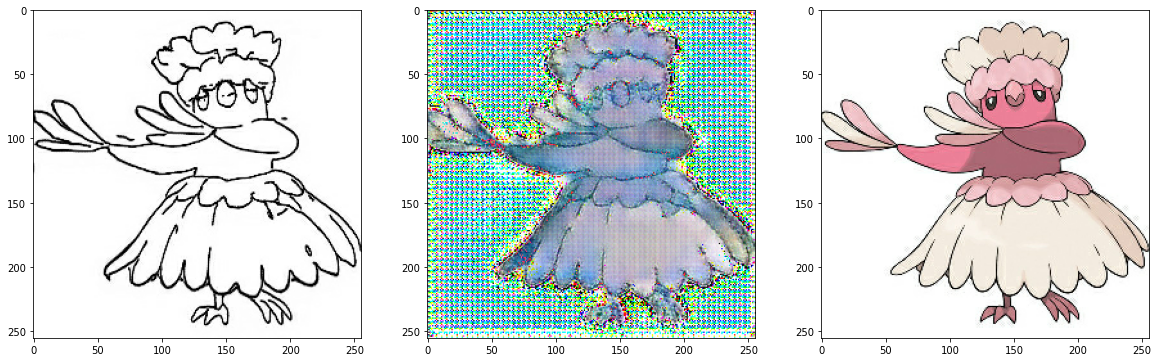

In [41]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

데이터셋을 제공한 출처를 보면, Pix2Pix로 128 epoch 학습 후 테스트 결과가 아래와 같다고 한다.

이전 10 epoch 학습의 결과보다는 훨씬 낫지만, 조금 오래 학습했어도 채색해야 할 전체적인 색감 정도만 학습되며 아직까지 세부적으로는 제대로 채색되지 않다는 것을 확인할 수 있다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/pokemon_result.max-800x600.png?raw=true)

지금까지 꽤 많은 시간을 투자해서 Encoder-Decoder Generator, U-Net Generator, Discriminator의 구현까지 이해하느라 고생했다. 앞서 다뤘던 코드의 이해에 큰 어려움이 없었다면, 연습을 통해 이와 비슷한 구조의 모델들 또한 쉽게 구현할 수 있을 것이다. (U-Net Generator를 구현했으니 원래 segmentation에 사용되었던 U-Net도 쉽게 구현할 수 있다!).

마지막으로 다음 단계로 넘어가서 Pix2Pix를 이용한 프로젝트를 수행해보자.


## 프로젝트 : Segmentation map으로 도로 이미지 만들기

이전 Pix2Pix 논문에서 제시한 결과 중에 아래와 같은 실험 결과가 있었다. 도로의 레이블 정보를 활용해 이미지를 생성해낸 결과다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/19/etc/p2p_result_seg.max-800x600.png?raw=true)

이번 프로젝트는 위와 같은 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것이다. 데이터셋은 아래에서 다운로드할 수 있다.

1000개의 학습용 이미지 및 5개의 평가 이미지를 포함한다.

이전 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 레이블 정보 이미지를 입력으로 사용하기 때문에, 전처리 과정에 대해 약간의 혼란이 있을 수 있지만 크게 다른 과정은 없다.
아래 Tensroflow에서 제공하는 Pix2Pix 튜토리얼은 위 이미지와 비슷한 레이블 정보 이미지를 사용하기 때문에 좋은 참고 자료가 될 수 있을 것 같다.

프로젝트 시작에 어려움이 있다면 아래 튜토리얼을 참고하시면서 이번 프로젝트를 수행해보자.

### 프로젝트 수행
--- 

프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

- 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요. (어떠한 방법을 사용했는지 적어주세요.)
- 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.
- 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.
- 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
- 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

데이터 준비, 불러오기 및 데이터 수 확인

$ mkdir -p ~/aiffel/EXPLORATION/19/conditional_generation/cityscapes

$ cd ~/aiffel/EXPLORATION/19/conditional_generation/cityscapes && unzip cityscapes.zip

In [44]:
import os

data_path = os.getenv('HOME')+'/aiffel/EXPLORATION/19/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


각각의 이미지들이 어떻게 생겼는지 확인( 임의로 6장을 선택하여 시각화)

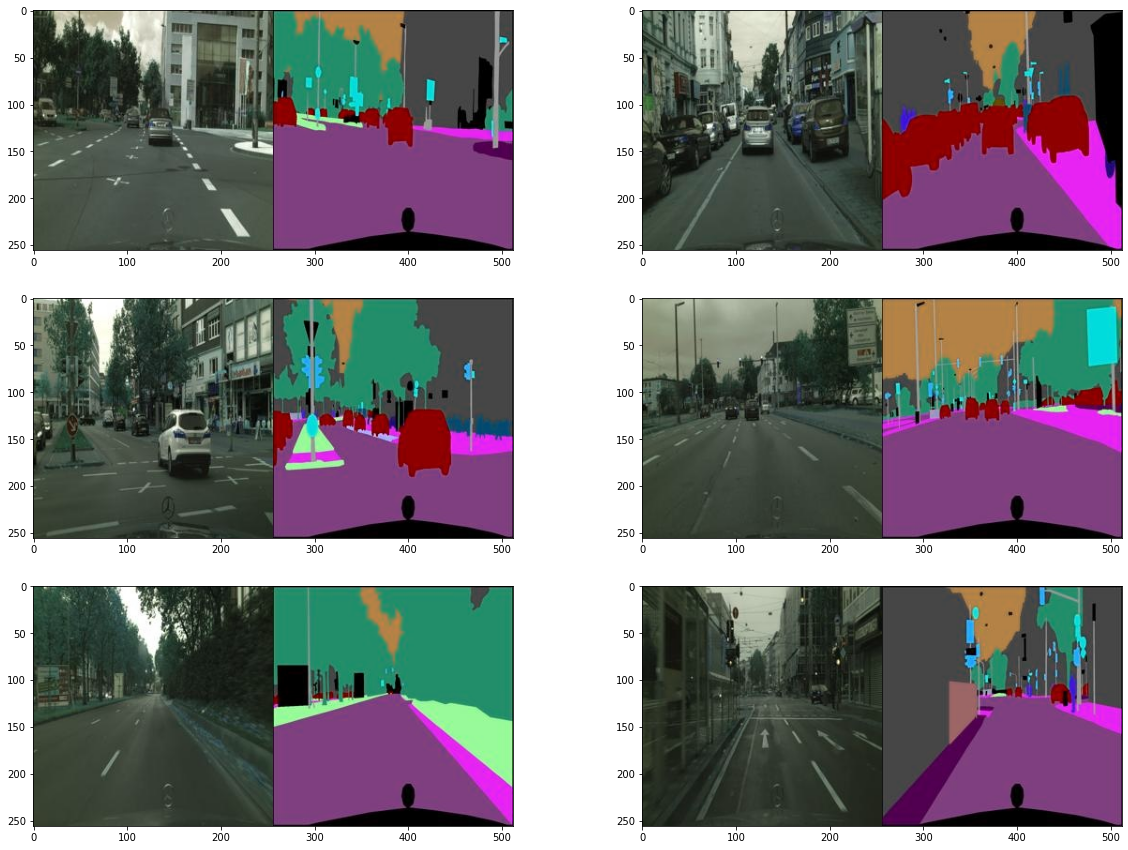

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

이미지를 하나 열어 아래와 같이 크기를 확인

In [46]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


(256, 512, 3)으로 확인되어 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할이 필요함

(256, 256, 3) 크기의 2개 이미지로 분할

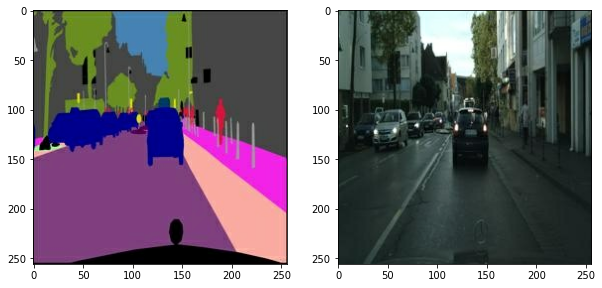

In [47]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :]  
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

학습에 사용하는 데이터의 다양성을 높이기 위해 여러 augmentation 방법을 적용

In [48]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")


✅


데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요. (어떠한 방법을 사용했는지 적어주세요.)

- tf.pad :: 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용
- tf.image.random_crop :: (256,256,6) 크기를 가진 이미지를 임의로 잘라냄
- tf.image.random_flip_left_right :: 50% 확률로 가로로 뒤집음
- tf.image.random_flip_up_down :: 50% 확률로 세로로 뒤집음
- tf.image.rot90 :: 50% 확률로 회전시킴


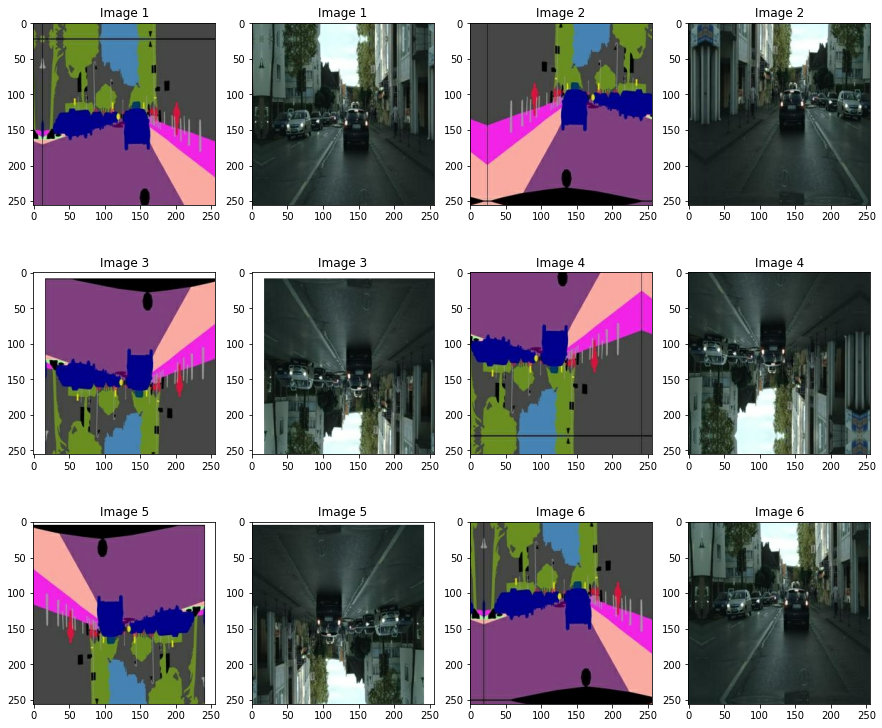

In [49]:
#Agumentation을 수행한 이미지들을 출력

plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

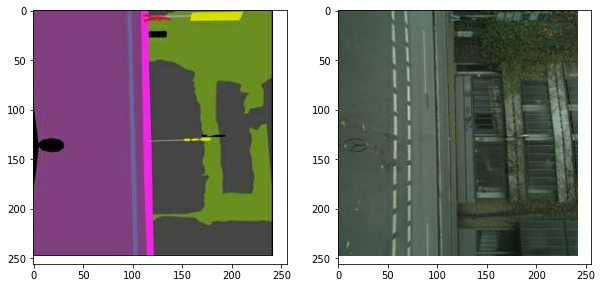

In [50]:
#잘 적용되었는지 하나의 이미지만 시각화하여 확인

from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))


Generator 구현하기

- "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 하나의 레이어로 만들기

In [51]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [52]:
#여러 번 가져다가 Encoder로 만들어 사용

class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [53]:
#Encoder model설계

Encoder().get_summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block_32 (EncodeBlock (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_33 (EncodeBlock (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_34 (EncodeBlock (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_35 (EncodeBlock (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_36 (EncodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_37 (EncodeBlock (None, 4, 4, 512)         4196

블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨을 확인 할 수 있음

Decoder를 구현

In [54]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


처음 세 개의 블록에서만 Dropout을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력하는 것을 확인할 수 있음

In [55]:
#Decoder model 설계

Decoder().get_summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block_28 (DecodeBlock (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_29 (DecodeBlock (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_30 (DecodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_31 (DecodeBlock (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_32 (DecodeBlock (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_33 (DecodeBlock (None, 64, 64, 128)       5248

(width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256,256,3) 크기로 알맞게 출력되었음.

In [56]:
# tf.keras.Model을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성

class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_3 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_3 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


Encoder 및 Decoder에 사용되는 기본적인 블록

In [57]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


U-Net Generator를 정의 (skip connection)

In [58]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.

In [59]:
#U-net의 출력을 확인
UNetGenerator().get_summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_48 (EncodeBlock)   (None, 128, 128, 64) 3072        input_11[0][0]                   
__________________________________________________________________________________________________
encode_block_49 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_48[0][0]            
__________________________________________________________________________________________________
encode_block_50 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_49[0][0]            
____________________________________________________________________________________________

Discriminator에 사용할 기본적인 블록 만들기

In [60]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")



✅


간단하게 코드를 작성하여 각 출력의 크기가 맞는지 확인

In [61]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_115 (Bat (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_69 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


Discriminator를 만들어보기

In [62]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # for loop로 간편하게 블록 만들기
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


각 블록의 출력 크기가 알맞게 되었는지 확인

In [63]:
Discriminator().get_summary()


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_24 (Concatenate)    (None, 256, 256, 6)  0           input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
disc_block_15 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_24[0][0]      

(256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화

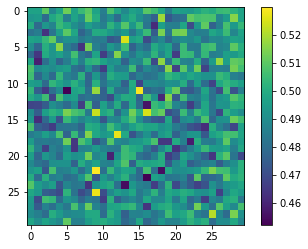

In [64]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

두 가지 손실 함수를 모두 사용

In [65]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


사용할 optimizer는 논문과 동일하게 설정

In [66]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정

In [67]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

In [68]:
EPOCHS = 200

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)

                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9428                     
L1_loss:0.3173                     
Discriminator_loss:1.3398

EPOCH[1] - STEP[20]                     
Generator_loss:1.0615                     
L1_loss:0.2337                     
Discriminator_loss:1.3816

EPOCH[1] - STEP[30]                     
Generator_loss:0.7712                     
L1_loss:0.2595                     
Discriminator_loss:1.4541

EPOCH[1] - STEP[40]                     
Generator_loss:1.0152                     
L1_loss:0.2129                     
Discriminator_loss:1.2682

EPOCH[1] - STEP[50]                     
Generator_loss:0.8594                     
L1_loss:0.1930                     
Discriminator_loss:1.2110

EPOCH[1] - STEP[60]                     
Generator_loss:0.9346                     
L1_loss:0.1578                     
Discriminator_loss:1.0675

EPOCH[1] - STEP[70]                     
Generator_loss:0.9764                     
L1_loss:0.1837                    

EPOCH[3] - STEP[70]                     
Generator_loss:0.6909                     
L1_loss:0.1991                     
Discriminator_loss:0.9149

EPOCH[3] - STEP[80]                     
Generator_loss:1.4399                     
L1_loss:0.1641                     
Discriminator_loss:1.3510

EPOCH[3] - STEP[90]                     
Generator_loss:0.1753                     
L1_loss:0.1674                     
Discriminator_loss:2.3940

EPOCH[3] - STEP[100]                     
Generator_loss:0.4437                     
L1_loss:0.1996                     
Discriminator_loss:1.3441

EPOCH[3] - STEP[110]                     
Generator_loss:1.7535                     
L1_loss:0.1446                     
Discriminator_loss:0.8705

EPOCH[3] - STEP[120]                     
Generator_loss:1.1798                     
L1_loss:0.2218                     
Discriminator_loss:0.8067

EPOCH[3] - STEP[130]                     
Generator_loss:1.9370                     
L1_loss:0.1884                

EPOCH[5] - STEP[130]                     
Generator_loss:1.1213                     
L1_loss:0.1864                     
Discriminator_loss:0.9525

EPOCH[5] - STEP[140]                     
Generator_loss:0.4849                     
L1_loss:0.1778                     
Discriminator_loss:1.2589

EPOCH[5] - STEP[150]                     
Generator_loss:1.5693                     
L1_loss:0.1990                     
Discriminator_loss:0.3241

EPOCH[5] - STEP[160]                     
Generator_loss:1.5072                     
L1_loss:0.1798                     
Discriminator_loss:0.6969

EPOCH[5] - STEP[170]                     
Generator_loss:2.5430                     
L1_loss:0.2065                     
Discriminator_loss:0.6020

EPOCH[5] - STEP[180]                     
Generator_loss:1.4868                     
L1_loss:0.2304                     
Discriminator_loss:2.1141

EPOCH[5] - STEP[190]                     
Generator_loss:0.4993                     
L1_loss:0.1639             

EPOCH[7] - STEP[190]                     
Generator_loss:0.3044                     
L1_loss:0.2051                     
Discriminator_loss:1.6957

EPOCH[7] - STEP[200]                     
Generator_loss:0.8270                     
L1_loss:0.1864                     
Discriminator_loss:0.9118

EPOCH[7] - STEP[210]                     
Generator_loss:1.9529                     
L1_loss:0.1624                     
Discriminator_loss:1.2591

EPOCH[7] - STEP[220]                     
Generator_loss:1.8781                     
L1_loss:0.1744                     
Discriminator_loss:0.3624

EPOCH[7] - STEP[230]                     
Generator_loss:1.3216                     
L1_loss:0.2248                     
Discriminator_loss:0.6373

EPOCH[7] - STEP[240]                     
Generator_loss:1.6193                     
L1_loss:0.1996                     
Discriminator_loss:0.3324

EPOCH[7] - STEP[250]                     
Generator_loss:0.5433                     
L1_loss:0.1690             

EPOCH[9] - STEP[250]                     
Generator_loss:1.3465                     
L1_loss:0.2033                     
Discriminator_loss:0.8034

EPOCH[10] - STEP[10]                     
Generator_loss:1.1203                     
L1_loss:0.1851                     
Discriminator_loss:0.5644

EPOCH[10] - STEP[20]                     
Generator_loss:0.9100                     
L1_loss:0.2076                     
Discriminator_loss:1.1321

EPOCH[10] - STEP[30]                     
Generator_loss:2.0632                     
L1_loss:0.1886                     
Discriminator_loss:0.3216

EPOCH[10] - STEP[40]                     
Generator_loss:1.8158                     
L1_loss:0.1550                     
Discriminator_loss:0.7727

EPOCH[10] - STEP[50]                     
Generator_loss:1.4906                     
L1_loss:0.1373                     
Discriminator_loss:0.9002

EPOCH[10] - STEP[60]                     
Generator_loss:1.1367                     
L1_loss:0.2062             

EPOCH[12] - STEP[60]                     
Generator_loss:0.9033                     
L1_loss:0.1890                     
Discriminator_loss:0.8217

EPOCH[12] - STEP[70]                     
Generator_loss:1.7287                     
L1_loss:0.1671                     
Discriminator_loss:1.0493

EPOCH[12] - STEP[80]                     
Generator_loss:0.7822                     
L1_loss:0.1890                     
Discriminator_loss:1.1723

EPOCH[12] - STEP[90]                     
Generator_loss:1.0609                     
L1_loss:0.1711                     
Discriminator_loss:0.7121

EPOCH[12] - STEP[100]                     
Generator_loss:2.4975                     
L1_loss:0.1701                     
Discriminator_loss:2.3382

EPOCH[12] - STEP[110]                     
Generator_loss:1.4407                     
L1_loss:0.2119                     
Discriminator_loss:0.4447

EPOCH[12] - STEP[120]                     
Generator_loss:1.0216                     
L1_loss:0.1802          

EPOCH[14] - STEP[120]                     
Generator_loss:0.1917                     
L1_loss:0.1290                     
Discriminator_loss:2.3296

EPOCH[14] - STEP[130]                     
Generator_loss:1.4589                     
L1_loss:0.1795                     
Discriminator_loss:0.9131

EPOCH[14] - STEP[140]                     
Generator_loss:1.5508                     
L1_loss:0.1494                     
Discriminator_loss:1.8404

EPOCH[14] - STEP[150]                     
Generator_loss:1.3932                     
L1_loss:0.1544                     
Discriminator_loss:0.8886

EPOCH[14] - STEP[160]                     
Generator_loss:1.6552                     
L1_loss:0.2274                     
Discriminator_loss:0.2756

EPOCH[14] - STEP[170]                     
Generator_loss:1.4351                     
L1_loss:0.2018                     
Discriminator_loss:0.3744

EPOCH[14] - STEP[180]                     
Generator_loss:0.4986                     
L1_loss:0.1920      

EPOCH[16] - STEP[180]                     
Generator_loss:1.6123                     
L1_loss:0.1815                     
Discriminator_loss:0.3213

EPOCH[16] - STEP[190]                     
Generator_loss:1.8210                     
L1_loss:0.1753                     
Discriminator_loss:1.0874

EPOCH[16] - STEP[200]                     
Generator_loss:1.3706                     
L1_loss:0.1570                     
Discriminator_loss:1.0363

EPOCH[16] - STEP[210]                     
Generator_loss:1.2499                     
L1_loss:0.1697                     
Discriminator_loss:0.5305

EPOCH[16] - STEP[220]                     
Generator_loss:0.7343                     
L1_loss:0.1642                     
Discriminator_loss:1.3641

EPOCH[16] - STEP[230]                     
Generator_loss:1.9416                     
L1_loss:0.1774                     
Discriminator_loss:1.2204

EPOCH[16] - STEP[240]                     
Generator_loss:1.2203                     
L1_loss:0.1651      

EPOCH[18] - STEP[240]                     
Generator_loss:2.1584                     
L1_loss:0.1964                     
Discriminator_loss:0.1944

EPOCH[18] - STEP[250]                     
Generator_loss:0.4760                     
L1_loss:0.1921                     
Discriminator_loss:1.0734

EPOCH[19] - STEP[10]                     
Generator_loss:0.3741                     
L1_loss:0.1419                     
Discriminator_loss:1.8706

EPOCH[19] - STEP[20]                     
Generator_loss:1.2094                     
L1_loss:0.2163                     
Discriminator_loss:0.6242

EPOCH[19] - STEP[30]                     
Generator_loss:0.7858                     
L1_loss:0.1680                     
Discriminator_loss:1.0134

EPOCH[19] - STEP[40]                     
Generator_loss:0.9914                     
L1_loss:0.1838                     
Discriminator_loss:0.5939

EPOCH[19] - STEP[50]                     
Generator_loss:0.1851                     
L1_loss:0.1918           

EPOCH[21] - STEP[50]                     
Generator_loss:1.7099                     
L1_loss:0.1560                     
Discriminator_loss:1.1465

EPOCH[21] - STEP[60]                     
Generator_loss:1.7332                     
L1_loss:0.1704                     
Discriminator_loss:0.5586

EPOCH[21] - STEP[70]                     
Generator_loss:0.8939                     
L1_loss:0.1871                     
Discriminator_loss:0.8662

EPOCH[21] - STEP[80]                     
Generator_loss:1.3241                     
L1_loss:0.1707                     
Discriminator_loss:1.0329

EPOCH[21] - STEP[90]                     
Generator_loss:0.2632                     
L1_loss:0.2183                     
Discriminator_loss:1.9919

EPOCH[21] - STEP[100]                     
Generator_loss:1.6082                     
L1_loss:0.1645                     
Discriminator_loss:0.3002

EPOCH[21] - STEP[110]                     
Generator_loss:1.9195                     
L1_loss:0.1714           

EPOCH[23] - STEP[110]                     
Generator_loss:0.5201                     
L1_loss:0.1713                     
Discriminator_loss:1.1940

EPOCH[23] - STEP[120]                     
Generator_loss:1.3928                     
L1_loss:0.1520                     
Discriminator_loss:1.0169

EPOCH[23] - STEP[130]                     
Generator_loss:0.6791                     
L1_loss:0.1921                     
Discriminator_loss:0.9203

EPOCH[23] - STEP[140]                     
Generator_loss:0.9584                     
L1_loss:0.1627                     
Discriminator_loss:0.8205

EPOCH[23] - STEP[150]                     
Generator_loss:2.0735                     
L1_loss:0.1754                     
Discriminator_loss:0.9142

EPOCH[23] - STEP[160]                     
Generator_loss:1.5923                     
L1_loss:0.1866                     
Discriminator_loss:0.6892

EPOCH[23] - STEP[170]                     
Generator_loss:1.4306                     
L1_loss:0.1338      

EPOCH[25] - STEP[170]                     
Generator_loss:2.4921                     
L1_loss:0.1864                     
Discriminator_loss:0.2310

EPOCH[25] - STEP[180]                     
Generator_loss:0.5996                     
L1_loss:0.1721                     
Discriminator_loss:1.1096

EPOCH[25] - STEP[190]                     
Generator_loss:2.2955                     
L1_loss:0.1618                     
Discriminator_loss:0.5573

EPOCH[25] - STEP[200]                     
Generator_loss:2.6212                     
L1_loss:0.1656                     
Discriminator_loss:1.0292

EPOCH[25] - STEP[210]                     
Generator_loss:1.2865                     
L1_loss:0.1964                     
Discriminator_loss:0.7588

EPOCH[25] - STEP[220]                     
Generator_loss:0.8106                     
L1_loss:0.1594                     
Discriminator_loss:0.8651

EPOCH[25] - STEP[230]                     
Generator_loss:0.4669                     
L1_loss:0.2055      

EPOCH[27] - STEP[230]                     
Generator_loss:1.1785                     
L1_loss:0.1899                     
Discriminator_loss:2.7733

EPOCH[27] - STEP[240]                     
Generator_loss:0.7124                     
L1_loss:0.2208                     
Discriminator_loss:0.8025

EPOCH[27] - STEP[250]                     
Generator_loss:1.5918                     
L1_loss:0.2015                     
Discriminator_loss:0.3283

EPOCH[28] - STEP[10]                     
Generator_loss:1.0264                     
L1_loss:0.1457                     
Discriminator_loss:0.9471

EPOCH[28] - STEP[20]                     
Generator_loss:1.1013                     
L1_loss:0.1801                     
Discriminator_loss:0.9713

EPOCH[28] - STEP[30]                     
Generator_loss:1.8661                     
L1_loss:0.1804                     
Discriminator_loss:1.0860

EPOCH[28] - STEP[40]                     
Generator_loss:0.6119                     
L1_loss:0.1816          

EPOCH[30] - STEP[40]                     
Generator_loss:0.6463                     
L1_loss:0.1682                     
Discriminator_loss:1.8965

EPOCH[30] - STEP[50]                     
Generator_loss:0.9578                     
L1_loss:0.1883                     
Discriminator_loss:0.7405

EPOCH[30] - STEP[60]                     
Generator_loss:0.8691                     
L1_loss:0.2028                     
Discriminator_loss:0.7665

EPOCH[30] - STEP[70]                     
Generator_loss:1.9803                     
L1_loss:0.1701                     
Discriminator_loss:0.9476

EPOCH[30] - STEP[80]                     
Generator_loss:0.4403                     
L1_loss:0.1734                     
Discriminator_loss:1.6225

EPOCH[30] - STEP[90]                     
Generator_loss:1.5337                     
L1_loss:0.1512                     
Discriminator_loss:1.2039

EPOCH[30] - STEP[100]                     
Generator_loss:0.6948                     
L1_loss:0.1646            

EPOCH[32] - STEP[100]                     
Generator_loss:1.7206                     
L1_loss:0.1720                     
Discriminator_loss:0.6441

EPOCH[32] - STEP[110]                     
Generator_loss:0.6460                     
L1_loss:0.1440                     
Discriminator_loss:1.6321

EPOCH[32] - STEP[120]                     
Generator_loss:0.9684                     
L1_loss:0.1440                     
Discriminator_loss:1.3481

EPOCH[32] - STEP[130]                     
Generator_loss:1.7896                     
L1_loss:0.1863                     
Discriminator_loss:0.3335

EPOCH[32] - STEP[140]                     
Generator_loss:1.7976                     
L1_loss:0.2214                     
Discriminator_loss:0.2203

EPOCH[32] - STEP[150]                     
Generator_loss:1.6139                     
L1_loss:0.1510                     
Discriminator_loss:1.5080

EPOCH[32] - STEP[160]                     
Generator_loss:1.4846                     
L1_loss:0.1516      

EPOCH[34] - STEP[160]                     
Generator_loss:0.7170                     
L1_loss:0.1648                     
Discriminator_loss:2.2126

EPOCH[34] - STEP[170]                     
Generator_loss:0.7642                     
L1_loss:0.1709                     
Discriminator_loss:0.8975

EPOCH[34] - STEP[180]                     
Generator_loss:0.5896                     
L1_loss:0.1672                     
Discriminator_loss:1.0862

EPOCH[34] - STEP[190]                     
Generator_loss:1.0628                     
L1_loss:0.1951                     
Discriminator_loss:0.8115

EPOCH[34] - STEP[200]                     
Generator_loss:0.7064                     
L1_loss:0.1758                     
Discriminator_loss:0.9714

EPOCH[34] - STEP[210]                     
Generator_loss:1.7287                     
L1_loss:0.1914                     
Discriminator_loss:0.4619

EPOCH[34] - STEP[220]                     
Generator_loss:2.0363                     
L1_loss:0.1622      

EPOCH[36] - STEP[220]                     
Generator_loss:1.4762                     
L1_loss:0.1595                     
Discriminator_loss:0.7950

EPOCH[36] - STEP[230]                     
Generator_loss:1.9526                     
L1_loss:0.1758                     
Discriminator_loss:0.4492

EPOCH[36] - STEP[240]                     
Generator_loss:0.8174                     
L1_loss:0.1832                     
Discriminator_loss:0.7691

EPOCH[36] - STEP[250]                     
Generator_loss:1.3808                     
L1_loss:0.1882                     
Discriminator_loss:0.3881

EPOCH[37] - STEP[10]                     
Generator_loss:1.6158                     
L1_loss:0.1892                     
Discriminator_loss:0.7844

EPOCH[37] - STEP[20]                     
Generator_loss:1.0603                     
L1_loss:0.1728                     
Discriminator_loss:1.0132

EPOCH[37] - STEP[30]                     
Generator_loss:1.3838                     
L1_loss:0.1487         

EPOCH[39] - STEP[30]                     
Generator_loss:1.5659                     
L1_loss:0.1946                     
Discriminator_loss:0.3355

EPOCH[39] - STEP[40]                     
Generator_loss:1.2782                     
L1_loss:0.1582                     
Discriminator_loss:0.8900

EPOCH[39] - STEP[50]                     
Generator_loss:1.2255                     
L1_loss:0.1949                     
Discriminator_loss:1.5855

EPOCH[39] - STEP[60]                     
Generator_loss:0.5552                     
L1_loss:0.1451                     
Discriminator_loss:1.3477

EPOCH[39] - STEP[70]                     
Generator_loss:2.2552                     
L1_loss:0.1641                     
Discriminator_loss:0.8856

EPOCH[39] - STEP[80]                     
Generator_loss:1.7258                     
L1_loss:0.1457                     
Discriminator_loss:1.1135

EPOCH[39] - STEP[90]                     
Generator_loss:2.1159                     
L1_loss:0.1510             

EPOCH[41] - STEP[90]                     
Generator_loss:0.7350                     
L1_loss:0.1559                     
Discriminator_loss:1.2543

EPOCH[41] - STEP[100]                     
Generator_loss:0.3369                     
L1_loss:0.1818                     
Discriminator_loss:1.4463

EPOCH[41] - STEP[110]                     
Generator_loss:1.3365                     
L1_loss:0.1615                     
Discriminator_loss:2.5364

EPOCH[41] - STEP[120]                     
Generator_loss:2.2284                     
L1_loss:0.1623                     
Discriminator_loss:1.2644

EPOCH[41] - STEP[130]                     
Generator_loss:2.3882                     
L1_loss:0.1876                     
Discriminator_loss:0.2337

EPOCH[41] - STEP[140]                     
Generator_loss:0.5737                     
L1_loss:0.2022                     
Discriminator_loss:1.2243

EPOCH[41] - STEP[150]                     
Generator_loss:0.9717                     
L1_loss:0.1550       

EPOCH[43] - STEP[150]                     
Generator_loss:1.4572                     
L1_loss:0.1679                     
Discriminator_loss:0.5008

EPOCH[43] - STEP[160]                     
Generator_loss:0.3925                     
L1_loss:0.1830                     
Discriminator_loss:1.3491

EPOCH[43] - STEP[170]                     
Generator_loss:1.2949                     
L1_loss:0.1986                     
Discriminator_loss:0.4094

EPOCH[43] - STEP[180]                     
Generator_loss:1.6992                     
L1_loss:0.1597                     
Discriminator_loss:1.1756

EPOCH[43] - STEP[190]                     
Generator_loss:1.5748                     
L1_loss:0.1622                     
Discriminator_loss:1.0325

EPOCH[43] - STEP[200]                     
Generator_loss:1.1865                     
L1_loss:0.1939                     
Discriminator_loss:0.7144

EPOCH[43] - STEP[210]                     
Generator_loss:1.3757                     
L1_loss:0.1807      

EPOCH[45] - STEP[210]                     
Generator_loss:1.1102                     
L1_loss:0.1761                     
Discriminator_loss:0.5057

EPOCH[45] - STEP[220]                     
Generator_loss:1.5368                     
L1_loss:0.1658                     
Discriminator_loss:0.6699

EPOCH[45] - STEP[230]                     
Generator_loss:1.6150                     
L1_loss:0.1725                     
Discriminator_loss:0.4656

EPOCH[45] - STEP[240]                     
Generator_loss:1.0211                     
L1_loss:0.1753                     
Discriminator_loss:2.0166

EPOCH[45] - STEP[250]                     
Generator_loss:1.0899                     
L1_loss:0.1725                     
Discriminator_loss:1.1709

EPOCH[46] - STEP[10]                     
Generator_loss:0.8643                     
L1_loss:0.2626                     
Discriminator_loss:0.6788

EPOCH[46] - STEP[20]                     
Generator_loss:1.1243                     
L1_loss:0.1863        

EPOCH[48] - STEP[20]                     
Generator_loss:1.3312                     
L1_loss:0.1666                     
Discriminator_loss:0.5345

EPOCH[48] - STEP[30]                     
Generator_loss:1.8041                     
L1_loss:0.1701                     
Discriminator_loss:0.8353

EPOCH[48] - STEP[40]                     
Generator_loss:0.7128                     
L1_loss:0.1615                     
Discriminator_loss:0.9528

EPOCH[48] - STEP[50]                     
Generator_loss:1.1508                     
L1_loss:0.1834                     
Discriminator_loss:1.0605

EPOCH[48] - STEP[60]                     
Generator_loss:2.0199                     
L1_loss:0.1909                     
Discriminator_loss:0.6569

EPOCH[48] - STEP[70]                     
Generator_loss:1.2333                     
L1_loss:0.1571                     
Discriminator_loss:0.8223

EPOCH[48] - STEP[80]                     
Generator_loss:1.8261                     
L1_loss:0.1591             

EPOCH[50] - STEP[80]                     
Generator_loss:3.0870                     
L1_loss:0.1932                     
Discriminator_loss:0.7343

EPOCH[50] - STEP[90]                     
Generator_loss:1.0877                     
L1_loss:0.1731                     
Discriminator_loss:0.6909

EPOCH[50] - STEP[100]                     
Generator_loss:1.3807                     
L1_loss:0.1785                     
Discriminator_loss:0.7779

EPOCH[50] - STEP[110]                     
Generator_loss:0.7037                     
L1_loss:0.1632                     
Discriminator_loss:1.0362

EPOCH[50] - STEP[120]                     
Generator_loss:2.2495                     
L1_loss:0.2392                     
Discriminator_loss:0.1422

EPOCH[50] - STEP[130]                     
Generator_loss:1.2445                     
L1_loss:0.1877                     
Discriminator_loss:0.4408

EPOCH[50] - STEP[140]                     
Generator_loss:1.0174                     
L1_loss:0.1639        

EPOCH[52] - STEP[140]                     
Generator_loss:1.1404                     
L1_loss:0.1928                     
Discriminator_loss:0.5234

EPOCH[52] - STEP[150]                     
Generator_loss:1.1673                     
L1_loss:0.1658                     
Discriminator_loss:0.5610

EPOCH[52] - STEP[160]                     
Generator_loss:2.3347                     
L1_loss:0.1550                     
Discriminator_loss:1.0645

EPOCH[52] - STEP[170]                     
Generator_loss:0.7826                     
L1_loss:0.1873                     
Discriminator_loss:2.4525

EPOCH[52] - STEP[180]                     
Generator_loss:0.8551                     
L1_loss:0.1456                     
Discriminator_loss:1.3401

EPOCH[52] - STEP[190]                     
Generator_loss:2.3730                     
L1_loss:0.1570                     
Discriminator_loss:1.9685

EPOCH[52] - STEP[200]                     
Generator_loss:2.3274                     
L1_loss:0.2048      

EPOCH[54] - STEP[200]                     
Generator_loss:0.9132                     
L1_loss:0.1684                     
Discriminator_loss:0.6737

EPOCH[54] - STEP[210]                     
Generator_loss:1.6179                     
L1_loss:0.1422                     
Discriminator_loss:2.3053

EPOCH[54] - STEP[220]                     
Generator_loss:2.4127                     
L1_loss:0.1753                     
Discriminator_loss:2.1310

EPOCH[54] - STEP[230]                     
Generator_loss:1.7008                     
L1_loss:0.1732                     
Discriminator_loss:0.4310

EPOCH[54] - STEP[240]                     
Generator_loss:1.2285                     
L1_loss:0.1555                     
Discriminator_loss:0.5428

EPOCH[54] - STEP[250]                     
Generator_loss:0.9944                     
L1_loss:0.1697                     
Discriminator_loss:0.5735

EPOCH[55] - STEP[10]                     
Generator_loss:1.2393                     
L1_loss:0.1537       

EPOCH[57] - STEP[10]                     
Generator_loss:0.7712                     
L1_loss:0.1654                     
Discriminator_loss:1.1847

EPOCH[57] - STEP[20]                     
Generator_loss:1.7373                     
L1_loss:0.1558                     
Discriminator_loss:0.3427

EPOCH[57] - STEP[30]                     
Generator_loss:2.1865                     
L1_loss:0.1766                     
Discriminator_loss:1.7554

EPOCH[57] - STEP[40]                     
Generator_loss:0.8515                     
L1_loss:0.1619                     
Discriminator_loss:0.7549

EPOCH[57] - STEP[50]                     
Generator_loss:1.2294                     
L1_loss:0.1716                     
Discriminator_loss:0.6267

EPOCH[57] - STEP[60]                     
Generator_loss:2.1397                     
L1_loss:0.1665                     
Discriminator_loss:0.3328

EPOCH[57] - STEP[70]                     
Generator_loss:1.1204                     
L1_loss:0.1753             

EPOCH[59] - STEP[70]                     
Generator_loss:1.0777                     
L1_loss:0.1899                     
Discriminator_loss:0.5786

EPOCH[59] - STEP[80]                     
Generator_loss:0.4094                     
L1_loss:0.1655                     
Discriminator_loss:1.3642

EPOCH[59] - STEP[90]                     
Generator_loss:0.6611                     
L1_loss:0.1950                     
Discriminator_loss:0.8460

EPOCH[59] - STEP[100]                     
Generator_loss:1.4777                     
L1_loss:0.1912                     
Discriminator_loss:1.5246

EPOCH[59] - STEP[110]                     
Generator_loss:0.7118                     
L1_loss:0.2142                     
Discriminator_loss:0.7843

EPOCH[59] - STEP[120]                     
Generator_loss:1.4387                     
L1_loss:0.1604                     
Discriminator_loss:0.9021

EPOCH[59] - STEP[130]                     
Generator_loss:0.5765                     
L1_loss:0.1690         

EPOCH[61] - STEP[130]                     
Generator_loss:2.2837                     
L1_loss:0.1651                     
Discriminator_loss:0.5991

EPOCH[61] - STEP[140]                     
Generator_loss:1.5164                     
L1_loss:0.1861                     
Discriminator_loss:1.2743

EPOCH[61] - STEP[150]                     
Generator_loss:1.7546                     
L1_loss:0.1897                     
Discriminator_loss:0.8444

EPOCH[61] - STEP[160]                     
Generator_loss:1.7075                     
L1_loss:0.1772                     
Discriminator_loss:1.7853

EPOCH[61] - STEP[170]                     
Generator_loss:1.2113                     
L1_loss:0.1388                     
Discriminator_loss:0.9430

EPOCH[61] - STEP[180]                     
Generator_loss:1.6128                     
L1_loss:0.1867                     
Discriminator_loss:0.3212

EPOCH[61] - STEP[190]                     
Generator_loss:0.7321                     
L1_loss:0.1526      

EPOCH[63] - STEP[190]                     
Generator_loss:0.6302                     
L1_loss:0.1633                     
Discriminator_loss:0.9527

EPOCH[63] - STEP[200]                     
Generator_loss:0.4818                     
L1_loss:0.1669                     
Discriminator_loss:1.5584

EPOCH[63] - STEP[210]                     
Generator_loss:1.5974                     
L1_loss:0.2092                     
Discriminator_loss:0.2898

EPOCH[63] - STEP[220]                     
Generator_loss:0.7883                     
L1_loss:0.1819                     
Discriminator_loss:0.7607

EPOCH[63] - STEP[230]                     
Generator_loss:1.0321                     
L1_loss:0.2379                     
Discriminator_loss:0.5210

EPOCH[63] - STEP[240]                     
Generator_loss:1.2726                     
L1_loss:0.1645                     
Discriminator_loss:1.1668

EPOCH[63] - STEP[250]                     
Generator_loss:0.2888                     
L1_loss:0.1576      

EPOCH[65] - STEP[250]                     
Generator_loss:1.4434                     
L1_loss:0.2208                     
Discriminator_loss:0.3869

EPOCH[66] - STEP[10]                     
Generator_loss:0.8403                     
L1_loss:0.1785                     
Discriminator_loss:1.0029

EPOCH[66] - STEP[20]                     
Generator_loss:1.2489                     
L1_loss:0.1979                     
Discriminator_loss:0.4077

EPOCH[66] - STEP[30]                     
Generator_loss:1.5307                     
L1_loss:0.1760                     
Discriminator_loss:0.3482

EPOCH[66] - STEP[40]                     
Generator_loss:1.7666                     
L1_loss:0.1430                     
Discriminator_loss:1.0960

EPOCH[66] - STEP[50]                     
Generator_loss:0.9996                     
L1_loss:0.1843                     
Discriminator_loss:2.8067

EPOCH[66] - STEP[60]                     
Generator_loss:1.3071                     
L1_loss:0.1700            

EPOCH[68] - STEP[60]                     
Generator_loss:1.2066                     
L1_loss:0.1684                     
Discriminator_loss:0.6810

EPOCH[68] - STEP[70]                     
Generator_loss:1.8393                     
L1_loss:0.1754                     
Discriminator_loss:1.3304

EPOCH[68] - STEP[80]                     
Generator_loss:2.2848                     
L1_loss:0.2042                     
Discriminator_loss:0.1482

EPOCH[68] - STEP[90]                     
Generator_loss:0.8983                     
L1_loss:0.1850                     
Discriminator_loss:0.7038

EPOCH[68] - STEP[100]                     
Generator_loss:0.9845                     
L1_loss:0.1857                     
Discriminator_loss:0.5849

EPOCH[68] - STEP[110]                     
Generator_loss:1.0368                     
L1_loss:0.1906                     
Discriminator_loss:0.6951

EPOCH[68] - STEP[120]                     
Generator_loss:1.3522                     
L1_loss:0.1598          

EPOCH[70] - STEP[120]                     
Generator_loss:0.4685                     
L1_loss:0.1574                     
Discriminator_loss:1.4959

EPOCH[70] - STEP[130]                     
Generator_loss:1.1754                     
L1_loss:0.1492                     
Discriminator_loss:0.9364

EPOCH[70] - STEP[140]                     
Generator_loss:1.4146                     
L1_loss:0.1989                     
Discriminator_loss:0.3945

EPOCH[70] - STEP[150]                     
Generator_loss:1.5950                     
L1_loss:0.2337                     
Discriminator_loss:0.2759

EPOCH[70] - STEP[160]                     
Generator_loss:1.1194                     
L1_loss:0.1553                     
Discriminator_loss:1.0185

EPOCH[70] - STEP[170]                     
Generator_loss:0.8028                     
L1_loss:0.1835                     
Discriminator_loss:0.9703

EPOCH[70] - STEP[180]                     
Generator_loss:1.2196                     
L1_loss:0.1688      

EPOCH[72] - STEP[180]                     
Generator_loss:1.1350                     
L1_loss:0.1684                     
Discriminator_loss:1.0648

EPOCH[72] - STEP[190]                     
Generator_loss:0.3649                     
L1_loss:0.1558                     
Discriminator_loss:1.3504

EPOCH[72] - STEP[200]                     
Generator_loss:2.0670                     
L1_loss:0.1720                     
Discriminator_loss:0.7414

EPOCH[72] - STEP[210]                     
Generator_loss:0.6758                     
L1_loss:0.1707                     
Discriminator_loss:0.9511

EPOCH[72] - STEP[220]                     
Generator_loss:2.1609                     
L1_loss:0.1530                     
Discriminator_loss:1.4950

EPOCH[72] - STEP[230]                     
Generator_loss:0.2156                     
L1_loss:0.1674                     
Discriminator_loss:1.8806

EPOCH[72] - STEP[240]                     
Generator_loss:2.2459                     
L1_loss:0.1730      

EPOCH[74] - STEP[240]                     
Generator_loss:1.7546                     
L1_loss:0.2062                     
Discriminator_loss:0.2656

EPOCH[74] - STEP[250]                     
Generator_loss:1.0984                     
L1_loss:0.1674                     
Discriminator_loss:1.1435

EPOCH[75] - STEP[10]                     
Generator_loss:0.8229                     
L1_loss:0.1799                     
Discriminator_loss:0.7807

EPOCH[75] - STEP[20]                     
Generator_loss:0.7063                     
L1_loss:0.1518                     
Discriminator_loss:1.0630

EPOCH[75] - STEP[30]                     
Generator_loss:0.9637                     
L1_loss:0.1677                     
Discriminator_loss:1.3790

EPOCH[75] - STEP[40]                     
Generator_loss:0.6351                     
L1_loss:0.1674                     
Discriminator_loss:1.5187

EPOCH[75] - STEP[50]                     
Generator_loss:1.2115                     
L1_loss:0.1737           

EPOCH[77] - STEP[50]                     
Generator_loss:1.4703                     
L1_loss:0.1582                     
Discriminator_loss:0.6671

EPOCH[77] - STEP[60]                     
Generator_loss:1.8525                     
L1_loss:0.1704                     
Discriminator_loss:1.6185

EPOCH[77] - STEP[70]                     
Generator_loss:0.8754                     
L1_loss:0.1708                     
Discriminator_loss:1.2884

EPOCH[77] - STEP[80]                     
Generator_loss:0.6065                     
L1_loss:0.1578                     
Discriminator_loss:1.0184

EPOCH[77] - STEP[90]                     
Generator_loss:0.8006                     
L1_loss:0.1669                     
Discriminator_loss:1.0944

EPOCH[77] - STEP[100]                     
Generator_loss:1.8044                     
L1_loss:0.1568                     
Discriminator_loss:0.7370

EPOCH[77] - STEP[110]                     
Generator_loss:2.1216                     
L1_loss:0.2006           

EPOCH[79] - STEP[110]                     
Generator_loss:0.8269                     
L1_loss:0.1812                     
Discriminator_loss:0.9443

EPOCH[79] - STEP[120]                     
Generator_loss:1.9042                     
L1_loss:0.1451                     
Discriminator_loss:1.4624

EPOCH[79] - STEP[130]                     
Generator_loss:1.1390                     
L1_loss:0.1450                     
Discriminator_loss:1.3322

EPOCH[79] - STEP[140]                     
Generator_loss:1.5720                     
L1_loss:0.1928                     
Discriminator_loss:0.7897

EPOCH[79] - STEP[150]                     
Generator_loss:0.5406                     
L1_loss:0.1688                     
Discriminator_loss:1.1442

EPOCH[79] - STEP[160]                     
Generator_loss:1.9408                     
L1_loss:0.2210                     
Discriminator_loss:0.2370

EPOCH[79] - STEP[170]                     
Generator_loss:2.3393                     
L1_loss:0.1887      

EPOCH[81] - STEP[170]                     
Generator_loss:1.3985                     
L1_loss:0.1763                     
Discriminator_loss:1.0827

EPOCH[81] - STEP[180]                     
Generator_loss:1.5875                     
L1_loss:0.1943                     
Discriminator_loss:0.5470

EPOCH[81] - STEP[190]                     
Generator_loss:1.7147                     
L1_loss:0.1758                     
Discriminator_loss:0.7788

EPOCH[81] - STEP[200]                     
Generator_loss:1.5147                     
L1_loss:0.1651                     
Discriminator_loss:0.6444

EPOCH[81] - STEP[210]                     
Generator_loss:2.4082                     
L1_loss:0.1723                     
Discriminator_loss:1.3396

EPOCH[81] - STEP[220]                     
Generator_loss:1.4025                     
L1_loss:0.1762                     
Discriminator_loss:0.5382

EPOCH[81] - STEP[230]                     
Generator_loss:1.5530                     
L1_loss:0.1808      

EPOCH[83] - STEP[230]                     
Generator_loss:1.7035                     
L1_loss:0.1707                     
Discriminator_loss:0.3931

EPOCH[83] - STEP[240]                     
Generator_loss:1.3404                     
L1_loss:0.1862                     
Discriminator_loss:0.4159

EPOCH[83] - STEP[250]                     
Generator_loss:1.5695                     
L1_loss:0.1698                     
Discriminator_loss:0.9038

EPOCH[84] - STEP[10]                     
Generator_loss:1.1601                     
L1_loss:0.1693                     
Discriminator_loss:2.2363

EPOCH[84] - STEP[20]                     
Generator_loss:1.4772                     
L1_loss:0.1979                     
Discriminator_loss:0.7062

EPOCH[84] - STEP[30]                     
Generator_loss:1.8377                     
L1_loss:0.1919                     
Discriminator_loss:0.4648

EPOCH[84] - STEP[40]                     
Generator_loss:1.2720                     
L1_loss:0.1890          

EPOCH[86] - STEP[40]                     
Generator_loss:1.4854                     
L1_loss:0.1861                     
Discriminator_loss:1.2255

EPOCH[86] - STEP[50]                     
Generator_loss:1.3119                     
L1_loss:0.2035                     
Discriminator_loss:0.3745

EPOCH[86] - STEP[60]                     
Generator_loss:1.3573                     
L1_loss:0.1562                     
Discriminator_loss:1.0053

EPOCH[86] - STEP[70]                     
Generator_loss:0.2684                     
L1_loss:0.1853                     
Discriminator_loss:1.6803

EPOCH[86] - STEP[80]                     
Generator_loss:1.6431                     
L1_loss:0.1505                     
Discriminator_loss:0.9045

EPOCH[86] - STEP[90]                     
Generator_loss:0.9979                     
L1_loss:0.1595                     
Discriminator_loss:0.8106

EPOCH[86] - STEP[100]                     
Generator_loss:2.1707                     
L1_loss:0.1660            

EPOCH[88] - STEP[100]                     
Generator_loss:1.3507                     
L1_loss:0.1621                     
Discriminator_loss:0.6765

EPOCH[88] - STEP[110]                     
Generator_loss:1.4811                     
L1_loss:0.1302                     
Discriminator_loss:0.9156

EPOCH[88] - STEP[120]                     
Generator_loss:1.7117                     
L1_loss:0.1515                     
Discriminator_loss:0.7260

EPOCH[88] - STEP[130]                     
Generator_loss:1.5682                     
L1_loss:0.1891                     
Discriminator_loss:0.4425

EPOCH[88] - STEP[140]                     
Generator_loss:0.6291                     
L1_loss:0.1692                     
Discriminator_loss:1.0330

EPOCH[88] - STEP[150]                     
Generator_loss:1.3986                     
L1_loss:0.1423                     
Discriminator_loss:1.1584

EPOCH[88] - STEP[160]                     
Generator_loss:0.5728                     
L1_loss:0.1856      

EPOCH[90] - STEP[160]                     
Generator_loss:1.1692                     
L1_loss:0.2304                     
Discriminator_loss:0.5213

EPOCH[90] - STEP[170]                     
Generator_loss:1.1070                     
L1_loss:0.1595                     
Discriminator_loss:0.8808

EPOCH[90] - STEP[180]                     
Generator_loss:1.3359                     
L1_loss:0.1539                     
Discriminator_loss:1.4874

EPOCH[90] - STEP[190]                     
Generator_loss:1.2790                     
L1_loss:0.1676                     
Discriminator_loss:0.9025

EPOCH[90] - STEP[200]                     
Generator_loss:2.2146                     
L1_loss:0.1571                     
Discriminator_loss:0.7831

EPOCH[90] - STEP[210]                     
Generator_loss:1.8061                     
L1_loss:0.1673                     
Discriminator_loss:0.7619

EPOCH[90] - STEP[220]                     
Generator_loss:2.7554                     
L1_loss:0.2012      

EPOCH[92] - STEP[220]                     
Generator_loss:0.6756                     
L1_loss:0.1672                     
Discriminator_loss:0.8725

EPOCH[92] - STEP[230]                     
Generator_loss:1.7070                     
L1_loss:0.1649                     
Discriminator_loss:0.5193

EPOCH[92] - STEP[240]                     
Generator_loss:1.1555                     
L1_loss:0.1764                     
Discriminator_loss:0.4971

EPOCH[92] - STEP[250]                     
Generator_loss:1.2911                     
L1_loss:0.1485                     
Discriminator_loss:1.5759

EPOCH[93] - STEP[10]                     
Generator_loss:1.6240                     
L1_loss:0.1625                     
Discriminator_loss:1.0023

EPOCH[93] - STEP[20]                     
Generator_loss:1.0432                     
L1_loss:0.1790                     
Discriminator_loss:1.5413

EPOCH[93] - STEP[30]                     
Generator_loss:0.9496                     
L1_loss:0.1445         

EPOCH[95] - STEP[30]                     
Generator_loss:0.9279                     
L1_loss:0.1456                     
Discriminator_loss:0.8754

EPOCH[95] - STEP[40]                     
Generator_loss:0.4105                     
L1_loss:0.1750                     
Discriminator_loss:2.0292

EPOCH[95] - STEP[50]                     
Generator_loss:0.9219                     
L1_loss:0.2118                     
Discriminator_loss:0.5973

EPOCH[95] - STEP[60]                     
Generator_loss:1.2008                     
L1_loss:0.1758                     
Discriminator_loss:0.4929

EPOCH[95] - STEP[70]                     
Generator_loss:0.9719                     
L1_loss:0.1753                     
Discriminator_loss:0.6107

EPOCH[95] - STEP[80]                     
Generator_loss:0.4679                     
L1_loss:0.1792                     
Discriminator_loss:1.1811

EPOCH[95] - STEP[90]                     
Generator_loss:1.2984                     
L1_loss:0.1971             

EPOCH[97] - STEP[90]                     
Generator_loss:0.7798                     
L1_loss:0.1520                     
Discriminator_loss:1.0913

EPOCH[97] - STEP[100]                     
Generator_loss:2.3745                     
L1_loss:0.2008                     
Discriminator_loss:0.2460

EPOCH[97] - STEP[110]                     
Generator_loss:2.5376                     
L1_loss:0.1907                     
Discriminator_loss:1.0630

EPOCH[97] - STEP[120]                     
Generator_loss:1.7104                     
L1_loss:0.1468                     
Discriminator_loss:1.0169

EPOCH[97] - STEP[130]                     
Generator_loss:3.0349                     
L1_loss:0.1609                     
Discriminator_loss:0.9100

EPOCH[97] - STEP[140]                     
Generator_loss:0.5428                     
L1_loss:0.1425                     
Discriminator_loss:1.4339

EPOCH[97] - STEP[150]                     
Generator_loss:0.5687                     
L1_loss:0.1597       

EPOCH[99] - STEP[150]                     
Generator_loss:2.3351                     
L1_loss:0.1784                     
Discriminator_loss:0.1761

EPOCH[99] - STEP[160]                     
Generator_loss:2.0349                     
L1_loss:0.1962                     
Discriminator_loss:0.2000

EPOCH[99] - STEP[170]                     
Generator_loss:1.3957                     
L1_loss:0.1711                     
Discriminator_loss:0.4950

EPOCH[99] - STEP[180]                     
Generator_loss:1.3048                     
L1_loss:0.1716                     
Discriminator_loss:0.9444

EPOCH[99] - STEP[190]                     
Generator_loss:1.6327                     
L1_loss:0.1704                     
Discriminator_loss:0.3058

EPOCH[99] - STEP[200]                     
Generator_loss:1.6697                     
L1_loss:0.1722                     
Discriminator_loss:1.8048

EPOCH[99] - STEP[210]                     
Generator_loss:0.7701                     
L1_loss:0.1780      

EPOCH[101] - STEP[200]                     
Generator_loss:1.1286                     
L1_loss:0.1684                     
Discriminator_loss:0.5089

EPOCH[101] - STEP[210]                     
Generator_loss:1.2436                     
L1_loss:0.1649                     
Discriminator_loss:1.2057

EPOCH[101] - STEP[220]                     
Generator_loss:1.0088                     
L1_loss:0.1486                     
Discriminator_loss:1.0436

EPOCH[101] - STEP[230]                     
Generator_loss:1.7511                     
L1_loss:0.1887                     
Discriminator_loss:0.2647

EPOCH[101] - STEP[240]                     
Generator_loss:1.0188                     
L1_loss:0.1746                     
Discriminator_loss:1.3567

EPOCH[101] - STEP[250]                     
Generator_loss:1.3939                     
L1_loss:0.1828                     
Discriminator_loss:0.3958

EPOCH[102] - STEP[10]                     
Generator_loss:1.8853                     
L1_loss:0.1683

EPOCH[103] - STEP[250]                     
Generator_loss:0.7885                     
L1_loss:0.1789                     
Discriminator_loss:1.1591

EPOCH[104] - STEP[10]                     
Generator_loss:2.3572                     
L1_loss:0.1594                     
Discriminator_loss:0.4316

EPOCH[104] - STEP[20]                     
Generator_loss:1.6251                     
L1_loss:0.1488                     
Discriminator_loss:0.8192

EPOCH[104] - STEP[30]                     
Generator_loss:1.2516                     
L1_loss:0.1547                     
Discriminator_loss:0.6413

EPOCH[104] - STEP[40]                     
Generator_loss:0.8674                     
L1_loss:0.1874                     
Discriminator_loss:0.7784

EPOCH[104] - STEP[50]                     
Generator_loss:1.4803                     
L1_loss:0.1556                     
Discriminator_loss:0.8389

EPOCH[104] - STEP[60]                     
Generator_loss:1.4399                     
L1_loss:0.1796     

EPOCH[106] - STEP[50]                     
Generator_loss:1.1777                     
L1_loss:0.1605                     
Discriminator_loss:0.9492

EPOCH[106] - STEP[60]                     
Generator_loss:1.7338                     
L1_loss:0.1772                     
Discriminator_loss:2.3484

EPOCH[106] - STEP[70]                     
Generator_loss:1.9334                     
L1_loss:0.1989                     
Discriminator_loss:0.2041

EPOCH[106] - STEP[80]                     
Generator_loss:1.9581                     
L1_loss:0.1531                     
Discriminator_loss:1.0183

EPOCH[106] - STEP[90]                     
Generator_loss:1.8365                     
L1_loss:0.2117                     
Discriminator_loss:0.2353

EPOCH[106] - STEP[100]                     
Generator_loss:1.7092                     
L1_loss:0.1808                     
Discriminator_loss:0.2716

EPOCH[106] - STEP[110]                     
Generator_loss:0.9751                     
L1_loss:0.2049    

EPOCH[108] - STEP[100]                     
Generator_loss:0.3736                     
L1_loss:0.1761                     
Discriminator_loss:1.4446

EPOCH[108] - STEP[110]                     
Generator_loss:1.4019                     
L1_loss:0.2178                     
Discriminator_loss:0.3486

EPOCH[108] - STEP[120]                     
Generator_loss:1.3208                     
L1_loss:0.1922                     
Discriminator_loss:0.6697

EPOCH[108] - STEP[130]                     
Generator_loss:1.2420                     
L1_loss:0.2068                     
Discriminator_loss:0.4304

EPOCH[108] - STEP[140]                     
Generator_loss:0.8405                     
L1_loss:0.1934                     
Discriminator_loss:0.6414

EPOCH[108] - STEP[150]                     
Generator_loss:0.8448                     
L1_loss:0.1855                     
Discriminator_loss:2.3404

EPOCH[108] - STEP[160]                     
Generator_loss:1.5144                     
L1_loss:0.176

EPOCH[110] - STEP[150]                     
Generator_loss:1.4410                     
L1_loss:0.1713                     
Discriminator_loss:0.4085

EPOCH[110] - STEP[160]                     
Generator_loss:1.4480                     
L1_loss:0.1563                     
Discriminator_loss:1.4776

EPOCH[110] - STEP[170]                     
Generator_loss:2.0399                     
L1_loss:0.1897                     
Discriminator_loss:0.1882

EPOCH[110] - STEP[180]                     
Generator_loss:0.8792                     
L1_loss:0.1729                     
Discriminator_loss:0.7909

EPOCH[110] - STEP[190]                     
Generator_loss:1.2277                     
L1_loss:0.1801                     
Discriminator_loss:1.0357

EPOCH[110] - STEP[200]                     
Generator_loss:1.6188                     
L1_loss:0.1715                     
Discriminator_loss:0.7105

EPOCH[110] - STEP[210]                     
Generator_loss:1.6762                     
L1_loss:0.213

EPOCH[112] - STEP[200]                     
Generator_loss:1.7241                     
L1_loss:0.1739                     
Discriminator_loss:1.5632

EPOCH[112] - STEP[210]                     
Generator_loss:1.4315                     
L1_loss:0.1648                     
Discriminator_loss:0.9910

EPOCH[112] - STEP[220]                     
Generator_loss:1.3859                     
L1_loss:0.1817                     
Discriminator_loss:0.9641

EPOCH[112] - STEP[230]                     
Generator_loss:0.6637                     
L1_loss:0.1617                     
Discriminator_loss:2.2472

EPOCH[112] - STEP[240]                     
Generator_loss:1.2101                     
L1_loss:0.1729                     
Discriminator_loss:0.4910

EPOCH[112] - STEP[250]                     
Generator_loss:1.5885                     
L1_loss:0.1483                     
Discriminator_loss:0.7653

EPOCH[113] - STEP[10]                     
Generator_loss:0.7773                     
L1_loss:0.1605

EPOCH[114] - STEP[250]                     
Generator_loss:1.2318                     
L1_loss:0.1857                     
Discriminator_loss:0.4308

EPOCH[115] - STEP[10]                     
Generator_loss:1.6954                     
L1_loss:0.1954                     
Discriminator_loss:0.4350

EPOCH[115] - STEP[20]                     
Generator_loss:0.7715                     
L1_loss:0.1562                     
Discriminator_loss:0.9973

EPOCH[115] - STEP[30]                     
Generator_loss:1.4191                     
L1_loss:0.1370                     
Discriminator_loss:1.6152

EPOCH[115] - STEP[40]                     
Generator_loss:2.3967                     
L1_loss:0.1868                     
Discriminator_loss:0.6941

EPOCH[115] - STEP[50]                     
Generator_loss:2.1199                     
L1_loss:0.2016                     
Discriminator_loss:0.2135

EPOCH[115] - STEP[60]                     
Generator_loss:1.7489                     
L1_loss:0.1688     

EPOCH[117] - STEP[50]                     
Generator_loss:1.3263                     
L1_loss:0.1695                     
Discriminator_loss:0.5848

EPOCH[117] - STEP[60]                     
Generator_loss:1.0162                     
L1_loss:0.1977                     
Discriminator_loss:1.1053

EPOCH[117] - STEP[70]                     
Generator_loss:1.1387                     
L1_loss:0.1699                     
Discriminator_loss:0.8635

EPOCH[117] - STEP[80]                     
Generator_loss:1.4346                     
L1_loss:0.1654                     
Discriminator_loss:0.6258

EPOCH[117] - STEP[90]                     
Generator_loss:1.4730                     
L1_loss:0.1754                     
Discriminator_loss:0.4868

EPOCH[117] - STEP[100]                     
Generator_loss:0.6244                     
L1_loss:0.1668                     
Discriminator_loss:1.6413

EPOCH[117] - STEP[110]                     
Generator_loss:0.9137                     
L1_loss:0.1838    

EPOCH[119] - STEP[100]                     
Generator_loss:1.1830                     
L1_loss:0.1896                     
Discriminator_loss:0.8160

EPOCH[119] - STEP[110]                     
Generator_loss:2.5929                     
L1_loss:0.1965                     
Discriminator_loss:0.2476

EPOCH[119] - STEP[120]                     
Generator_loss:0.7346                     
L1_loss:0.1488                     
Discriminator_loss:1.2306

EPOCH[119] - STEP[130]                     
Generator_loss:1.0904                     
L1_loss:0.1726                     
Discriminator_loss:0.6614

EPOCH[119] - STEP[140]                     
Generator_loss:1.2391                     
L1_loss:0.1983                     
Discriminator_loss:0.4181

EPOCH[119] - STEP[150]                     
Generator_loss:1.3932                     
L1_loss:0.2124                     
Discriminator_loss:0.5206

EPOCH[119] - STEP[160]                     
Generator_loss:1.5050                     
L1_loss:0.181

EPOCH[121] - STEP[150]                     
Generator_loss:1.4528                     
L1_loss:0.1493                     
Discriminator_loss:1.7105

EPOCH[121] - STEP[160]                     
Generator_loss:1.3060                     
L1_loss:0.1906                     
Discriminator_loss:0.4533

EPOCH[121] - STEP[170]                     
Generator_loss:1.5958                     
L1_loss:0.1839                     
Discriminator_loss:0.5211

EPOCH[121] - STEP[180]                     
Generator_loss:1.8781                     
L1_loss:0.1510                     
Discriminator_loss:0.4958

EPOCH[121] - STEP[190]                     
Generator_loss:1.0290                     
L1_loss:0.1734                     
Discriminator_loss:0.9256

EPOCH[121] - STEP[200]                     
Generator_loss:1.4582                     
L1_loss:0.1483                     
Discriminator_loss:1.2264

EPOCH[121] - STEP[210]                     
Generator_loss:1.5561                     
L1_loss:0.173

EPOCH[123] - STEP[200]                     
Generator_loss:2.1722                     
L1_loss:0.1604                     
Discriminator_loss:0.5809

EPOCH[123] - STEP[210]                     
Generator_loss:0.7504                     
L1_loss:0.1946                     
Discriminator_loss:0.7356

EPOCH[123] - STEP[220]                     
Generator_loss:1.0641                     
L1_loss:0.1780                     
Discriminator_loss:0.7902

EPOCH[123] - STEP[230]                     
Generator_loss:1.9039                     
L1_loss:0.1590                     
Discriminator_loss:1.6673

EPOCH[123] - STEP[240]                     
Generator_loss:2.0090                     
L1_loss:0.1665                     
Discriminator_loss:0.7441

EPOCH[123] - STEP[250]                     
Generator_loss:2.0746                     
L1_loss:0.2105                     
Discriminator_loss:0.3178

EPOCH[124] - STEP[10]                     
Generator_loss:1.4391                     
L1_loss:0.1513

EPOCH[125] - STEP[250]                     
Generator_loss:1.5463                     
L1_loss:0.1515                     
Discriminator_loss:1.2517

EPOCH[126] - STEP[10]                     
Generator_loss:1.6507                     
L1_loss:0.1946                     
Discriminator_loss:0.5724

EPOCH[126] - STEP[20]                     
Generator_loss:0.2673                     
L1_loss:0.1804                     
Discriminator_loss:1.6228

EPOCH[126] - STEP[30]                     
Generator_loss:1.1167                     
L1_loss:0.1472                     
Discriminator_loss:1.5651

EPOCH[126] - STEP[40]                     
Generator_loss:1.9870                     
L1_loss:0.1473                     
Discriminator_loss:1.5172

EPOCH[126] - STEP[50]                     
Generator_loss:1.1118                     
L1_loss:0.1550                     
Discriminator_loss:0.8438

EPOCH[126] - STEP[60]                     
Generator_loss:1.2906                     
L1_loss:0.1590     

EPOCH[128] - STEP[50]                     
Generator_loss:1.6766                     
L1_loss:0.1521                     
Discriminator_loss:2.2480

EPOCH[128] - STEP[60]                     
Generator_loss:0.8056                     
L1_loss:0.1296                     
Discriminator_loss:1.2216

EPOCH[128] - STEP[70]                     
Generator_loss:1.5691                     
L1_loss:0.1954                     
Discriminator_loss:0.3267

EPOCH[128] - STEP[80]                     
Generator_loss:0.9239                     
L1_loss:0.1583                     
Discriminator_loss:0.9154

EPOCH[128] - STEP[90]                     
Generator_loss:1.0098                     
L1_loss:0.1654                     
Discriminator_loss:0.7960

EPOCH[128] - STEP[100]                     
Generator_loss:1.1714                     
L1_loss:0.1933                     
Discriminator_loss:0.4275

EPOCH[128] - STEP[110]                     
Generator_loss:0.9450                     
L1_loss:0.1966    

EPOCH[130] - STEP[100]                     
Generator_loss:1.4834                     
L1_loss:0.2012                     
Discriminator_loss:0.3199

EPOCH[130] - STEP[110]                     
Generator_loss:1.1625                     
L1_loss:0.1538                     
Discriminator_loss:0.8842

EPOCH[130] - STEP[120]                     
Generator_loss:0.9356                     
L1_loss:0.1671                     
Discriminator_loss:0.8889

EPOCH[130] - STEP[130]                     
Generator_loss:1.7767                     
L1_loss:0.1748                     
Discriminator_loss:2.3396

EPOCH[130] - STEP[140]                     
Generator_loss:1.8216                     
L1_loss:0.1511                     
Discriminator_loss:0.8534

EPOCH[130] - STEP[150]                     
Generator_loss:0.9185                     
L1_loss:0.1644                     
Discriminator_loss:0.7908

EPOCH[130] - STEP[160]                     
Generator_loss:1.7911                     
L1_loss:0.165

EPOCH[132] - STEP[150]                     
Generator_loss:0.8526                     
L1_loss:0.1668                     
Discriminator_loss:0.8578

EPOCH[132] - STEP[160]                     
Generator_loss:1.1635                     
L1_loss:0.2216                     
Discriminator_loss:0.4688

EPOCH[132] - STEP[170]                     
Generator_loss:1.5459                     
L1_loss:0.1715                     
Discriminator_loss:0.5137

EPOCH[132] - STEP[180]                     
Generator_loss:0.9602                     
L1_loss:0.2047                     
Discriminator_loss:0.5754

EPOCH[132] - STEP[190]                     
Generator_loss:1.8176                     
L1_loss:0.1690                     
Discriminator_loss:0.6901

EPOCH[132] - STEP[200]                     
Generator_loss:1.8353                     
L1_loss:0.1744                     
Discriminator_loss:0.2497

EPOCH[132] - STEP[210]                     
Generator_loss:2.1845                     
L1_loss:0.176

EPOCH[134] - STEP[200]                     
Generator_loss:1.6237                     
L1_loss:0.1569                     
Discriminator_loss:0.7138

EPOCH[134] - STEP[210]                     
Generator_loss:1.0728                     
L1_loss:0.1540                     
Discriminator_loss:0.7390

EPOCH[134] - STEP[220]                     
Generator_loss:1.0870                     
L1_loss:0.1744                     
Discriminator_loss:0.8272

EPOCH[134] - STEP[230]                     
Generator_loss:1.9141                     
L1_loss:0.1457                     
Discriminator_loss:1.3563

EPOCH[134] - STEP[240]                     
Generator_loss:2.3509                     
L1_loss:0.1489                     
Discriminator_loss:1.8467

EPOCH[134] - STEP[250]                     
Generator_loss:1.9666                     
L1_loss:0.1547                     
Discriminator_loss:0.6711

EPOCH[135] - STEP[10]                     
Generator_loss:1.7519                     
L1_loss:0.1980

EPOCH[136] - STEP[250]                     
Generator_loss:1.2116                     
L1_loss:0.1716                     
Discriminator_loss:0.9213

EPOCH[137] - STEP[10]                     
Generator_loss:1.7319                     
L1_loss:0.1415                     
Discriminator_loss:0.5918

EPOCH[137] - STEP[20]                     
Generator_loss:1.3233                     
L1_loss:0.1597                     
Discriminator_loss:1.2233

EPOCH[137] - STEP[30]                     
Generator_loss:0.5247                     
L1_loss:0.1606                     
Discriminator_loss:2.1835

EPOCH[137] - STEP[40]                     
Generator_loss:1.7254                     
L1_loss:0.1636                     
Discriminator_loss:0.6946

EPOCH[137] - STEP[50]                     
Generator_loss:1.4088                     
L1_loss:0.1536                     
Discriminator_loss:1.2873

EPOCH[137] - STEP[60]                     
Generator_loss:0.9543                     
L1_loss:0.1488     

EPOCH[139] - STEP[50]                     
Generator_loss:1.7159                     
L1_loss:0.1439                     
Discriminator_loss:0.9721

EPOCH[139] - STEP[60]                     
Generator_loss:2.0365                     
L1_loss:0.1623                     
Discriminator_loss:0.4914

EPOCH[139] - STEP[70]                     
Generator_loss:1.6390                     
L1_loss:0.1631                     
Discriminator_loss:0.8259

EPOCH[139] - STEP[80]                     
Generator_loss:1.1379                     
L1_loss:0.1860                     
Discriminator_loss:0.8465

EPOCH[139] - STEP[90]                     
Generator_loss:1.5951                     
L1_loss:0.1839                     
Discriminator_loss:0.3899

EPOCH[139] - STEP[100]                     
Generator_loss:1.0337                     
L1_loss:0.1436                     
Discriminator_loss:1.2905

EPOCH[139] - STEP[110]                     
Generator_loss:2.4445                     
L1_loss:0.1697    

EPOCH[141] - STEP[100]                     
Generator_loss:1.7636                     
L1_loss:0.1628                     
Discriminator_loss:0.3609

EPOCH[141] - STEP[110]                     
Generator_loss:1.4387                     
L1_loss:0.1645                     
Discriminator_loss:1.6249

EPOCH[141] - STEP[120]                     
Generator_loss:1.0797                     
L1_loss:0.1595                     
Discriminator_loss:0.9943

EPOCH[141] - STEP[130]                     
Generator_loss:0.5181                     
L1_loss:0.1690                     
Discriminator_loss:2.0873

EPOCH[141] - STEP[140]                     
Generator_loss:1.3284                     
L1_loss:0.1471                     
Discriminator_loss:1.1657

EPOCH[141] - STEP[150]                     
Generator_loss:0.7529                     
L1_loss:0.1795                     
Discriminator_loss:0.8338

EPOCH[141] - STEP[160]                     
Generator_loss:0.5774                     
L1_loss:0.130

EPOCH[143] - STEP[150]                     
Generator_loss:1.7607                     
L1_loss:0.1524                     
Discriminator_loss:1.0979

EPOCH[143] - STEP[160]                     
Generator_loss:1.7263                     
L1_loss:0.1840                     
Discriminator_loss:0.3438

EPOCH[143] - STEP[170]                     
Generator_loss:0.6825                     
L1_loss:0.1672                     
Discriminator_loss:1.0280

EPOCH[143] - STEP[180]                     
Generator_loss:0.9603                     
L1_loss:0.1977                     
Discriminator_loss:0.6095

EPOCH[143] - STEP[190]                     
Generator_loss:0.4164                     
L1_loss:0.1841                     
Discriminator_loss:1.3139

EPOCH[143] - STEP[200]                     
Generator_loss:1.5841                     
L1_loss:0.1700                     
Discriminator_loss:0.7039

EPOCH[143] - STEP[210]                     
Generator_loss:0.6239                     
L1_loss:0.179

EPOCH[145] - STEP[200]                     
Generator_loss:1.8761                     
L1_loss:0.1812                     
Discriminator_loss:0.3248

EPOCH[145] - STEP[210]                     
Generator_loss:0.2548                     
L1_loss:0.1695                     
Discriminator_loss:1.8822

EPOCH[145] - STEP[220]                     
Generator_loss:1.3965                     
L1_loss:0.1548                     
Discriminator_loss:1.0795

EPOCH[145] - STEP[230]                     
Generator_loss:2.1643                     
L1_loss:0.1976                     
Discriminator_loss:0.2844

EPOCH[145] - STEP[240]                     
Generator_loss:0.4326                     
L1_loss:0.1501                     
Discriminator_loss:2.2288

EPOCH[145] - STEP[250]                     
Generator_loss:1.7777                     
L1_loss:0.1886                     
Discriminator_loss:0.2683

EPOCH[146] - STEP[10]                     
Generator_loss:1.4546                     
L1_loss:0.1795

EPOCH[147] - STEP[250]                     
Generator_loss:1.1851                     
L1_loss:0.1789                     
Discriminator_loss:0.5222

EPOCH[148] - STEP[10]                     
Generator_loss:1.1028                     
L1_loss:0.1614                     
Discriminator_loss:1.0359

EPOCH[148] - STEP[20]                     
Generator_loss:1.2654                     
L1_loss:0.1430                     
Discriminator_loss:1.4287

EPOCH[148] - STEP[30]                     
Generator_loss:2.1426                     
L1_loss:0.1883                     
Discriminator_loss:0.2901

EPOCH[148] - STEP[40]                     
Generator_loss:1.2167                     
L1_loss:0.1534                     
Discriminator_loss:0.9494

EPOCH[148] - STEP[50]                     
Generator_loss:1.4838                     
L1_loss:0.1573                     
Discriminator_loss:0.3739

EPOCH[148] - STEP[60]                     
Generator_loss:2.3236                     
L1_loss:0.2071     

EPOCH[150] - STEP[50]                     
Generator_loss:1.0638                     
L1_loss:0.1749                     
Discriminator_loss:0.5077

EPOCH[150] - STEP[60]                     
Generator_loss:1.0596                     
L1_loss:0.1805                     
Discriminator_loss:1.0072

EPOCH[150] - STEP[70]                     
Generator_loss:0.9740                     
L1_loss:0.2014                     
Discriminator_loss:0.9205

EPOCH[150] - STEP[80]                     
Generator_loss:1.8643                     
L1_loss:0.1514                     
Discriminator_loss:1.0262

EPOCH[150] - STEP[90]                     
Generator_loss:0.7240                     
L1_loss:0.2134                     
Discriminator_loss:0.7600

EPOCH[150] - STEP[100]                     
Generator_loss:1.6246                     
L1_loss:0.1862                     
Discriminator_loss:0.3930

EPOCH[150] - STEP[110]                     
Generator_loss:1.7926                     
L1_loss:0.1773    

EPOCH[152] - STEP[100]                     
Generator_loss:1.7669                     
L1_loss:0.1654                     
Discriminator_loss:0.7484

EPOCH[152] - STEP[110]                     
Generator_loss:0.6476                     
L1_loss:0.1406                     
Discriminator_loss:1.4853

EPOCH[152] - STEP[120]                     
Generator_loss:1.0390                     
L1_loss:0.1697                     
Discriminator_loss:1.8069

EPOCH[152] - STEP[130]                     
Generator_loss:0.8568                     
L1_loss:0.2184                     
Discriminator_loss:0.6502

EPOCH[152] - STEP[140]                     
Generator_loss:1.1987                     
L1_loss:0.1592                     
Discriminator_loss:0.8056

EPOCH[152] - STEP[150]                     
Generator_loss:1.3878                     
L1_loss:0.1453                     
Discriminator_loss:0.8419

EPOCH[152] - STEP[160]                     
Generator_loss:1.8317                     
L1_loss:0.163

EPOCH[154] - STEP[150]                     
Generator_loss:2.2859                     
L1_loss:0.1713                     
Discriminator_loss:1.8335

EPOCH[154] - STEP[160]                     
Generator_loss:1.6296                     
L1_loss:0.1524                     
Discriminator_loss:1.0243

EPOCH[154] - STEP[170]                     
Generator_loss:1.0625                     
L1_loss:0.1477                     
Discriminator_loss:0.7041

EPOCH[154] - STEP[180]                     
Generator_loss:2.1898                     
L1_loss:0.1561                     
Discriminator_loss:1.1577

EPOCH[154] - STEP[190]                     
Generator_loss:0.7836                     
L1_loss:0.1796                     
Discriminator_loss:0.8347

EPOCH[154] - STEP[200]                     
Generator_loss:2.2506                     
L1_loss:0.1404                     
Discriminator_loss:1.5768

EPOCH[154] - STEP[210]                     
Generator_loss:0.8311                     
L1_loss:0.153

EPOCH[156] - STEP[200]                     
Generator_loss:2.0028                     
L1_loss:0.1731                     
Discriminator_loss:0.6573

EPOCH[156] - STEP[210]                     
Generator_loss:1.0404                     
L1_loss:0.1800                     
Discriminator_loss:0.7295

EPOCH[156] - STEP[220]                     
Generator_loss:1.5174                     
L1_loss:0.1716                     
Discriminator_loss:1.1404

EPOCH[156] - STEP[230]                     
Generator_loss:1.3044                     
L1_loss:0.1631                     
Discriminator_loss:0.8923

EPOCH[156] - STEP[240]                     
Generator_loss:1.7752                     
L1_loss:0.1500                     
Discriminator_loss:1.0352

EPOCH[156] - STEP[250]                     
Generator_loss:1.5163                     
L1_loss:0.1837                     
Discriminator_loss:0.3330

EPOCH[157] - STEP[10]                     
Generator_loss:1.9272                     
L1_loss:0.1641

EPOCH[158] - STEP[250]                     
Generator_loss:1.3051                     
L1_loss:0.1814                     
Discriminator_loss:0.4017

EPOCH[159] - STEP[10]                     
Generator_loss:1.0728                     
L1_loss:0.1601                     
Discriminator_loss:1.7618

EPOCH[159] - STEP[20]                     
Generator_loss:0.6238                     
L1_loss:0.1600                     
Discriminator_loss:1.3002

EPOCH[159] - STEP[30]                     
Generator_loss:1.1821                     
L1_loss:0.1527                     
Discriminator_loss:0.7024

EPOCH[159] - STEP[40]                     
Generator_loss:1.6884                     
L1_loss:0.1562                     
Discriminator_loss:0.4272

EPOCH[159] - STEP[50]                     
Generator_loss:1.3177                     
L1_loss:0.1707                     
Discriminator_loss:0.8964

EPOCH[159] - STEP[60]                     
Generator_loss:0.6135                     
L1_loss:0.1940     

EPOCH[161] - STEP[50]                     
Generator_loss:1.6203                     
L1_loss:0.1676                     
Discriminator_loss:0.9048

EPOCH[161] - STEP[60]                     
Generator_loss:1.9607                     
L1_loss:0.1564                     
Discriminator_loss:0.6057

EPOCH[161] - STEP[70]                     
Generator_loss:1.0055                     
L1_loss:0.2233                     
Discriminator_loss:0.5943

EPOCH[161] - STEP[80]                     
Generator_loss:0.8345                     
L1_loss:0.1918                     
Discriminator_loss:0.7376

EPOCH[161] - STEP[90]                     
Generator_loss:0.4296                     
L1_loss:0.1609                     
Discriminator_loss:1.7958

EPOCH[161] - STEP[100]                     
Generator_loss:2.0104                     
L1_loss:0.1840                     
Discriminator_loss:0.3476

EPOCH[161] - STEP[110]                     
Generator_loss:1.8313                     
L1_loss:0.1828    

EPOCH[163] - STEP[100]                     
Generator_loss:1.3717                     
L1_loss:0.1681                     
Discriminator_loss:0.8633

EPOCH[163] - STEP[110]                     
Generator_loss:0.7406                     
L1_loss:0.1943                     
Discriminator_loss:0.7834

EPOCH[163] - STEP[120]                     
Generator_loss:0.9822                     
L1_loss:0.1804                     
Discriminator_loss:0.7406

EPOCH[163] - STEP[130]                     
Generator_loss:1.5808                     
L1_loss:0.1566                     
Discriminator_loss:1.0211

EPOCH[163] - STEP[140]                     
Generator_loss:0.9671                     
L1_loss:0.1674                     
Discriminator_loss:1.5367

EPOCH[163] - STEP[150]                     
Generator_loss:1.4934                     
L1_loss:0.1774                     
Discriminator_loss:0.3239

EPOCH[163] - STEP[160]                     
Generator_loss:0.9457                     
L1_loss:0.165

EPOCH[165] - STEP[150]                     
Generator_loss:0.7598                     
L1_loss:0.1669                     
Discriminator_loss:1.2559

EPOCH[165] - STEP[160]                     
Generator_loss:1.8999                     
L1_loss:0.1827                     
Discriminator_loss:0.4352

EPOCH[165] - STEP[170]                     
Generator_loss:1.3079                     
L1_loss:0.1550                     
Discriminator_loss:1.0812

EPOCH[165] - STEP[180]                     
Generator_loss:1.7413                     
L1_loss:0.1391                     
Discriminator_loss:1.0339

EPOCH[165] - STEP[190]                     
Generator_loss:1.5537                     
L1_loss:0.1661                     
Discriminator_loss:1.0015

EPOCH[165] - STEP[200]                     
Generator_loss:0.3732                     
L1_loss:0.2066                     
Discriminator_loss:1.4558

EPOCH[165] - STEP[210]                     
Generator_loss:1.5611                     
L1_loss:0.180

EPOCH[167] - STEP[200]                     
Generator_loss:1.3881                     
L1_loss:0.1758                     
Discriminator_loss:0.8510

EPOCH[167] - STEP[210]                     
Generator_loss:0.9432                     
L1_loss:0.1418                     
Discriminator_loss:1.0053

EPOCH[167] - STEP[220]                     
Generator_loss:0.9167                     
L1_loss:0.1786                     
Discriminator_loss:0.9823

EPOCH[167] - STEP[230]                     
Generator_loss:1.3921                     
L1_loss:0.1558                     
Discriminator_loss:0.6785

EPOCH[167] - STEP[240]                     
Generator_loss:1.1571                     
L1_loss:0.1664                     
Discriminator_loss:1.2965

EPOCH[167] - STEP[250]                     
Generator_loss:1.2434                     
L1_loss:0.1990                     
Discriminator_loss:0.4255

EPOCH[168] - STEP[10]                     
Generator_loss:1.2183                     
L1_loss:0.1830

EPOCH[169] - STEP[250]                     
Generator_loss:1.1756                     
L1_loss:0.1973                     
Discriminator_loss:0.5346

EPOCH[170] - STEP[10]                     
Generator_loss:0.6428                     
L1_loss:0.1516                     
Discriminator_loss:0.9529

EPOCH[170] - STEP[20]                     
Generator_loss:2.2621                     
L1_loss:0.1547                     
Discriminator_loss:1.5345

EPOCH[170] - STEP[30]                     
Generator_loss:1.0601                     
L1_loss:0.1665                     
Discriminator_loss:1.6916

EPOCH[170] - STEP[40]                     
Generator_loss:2.0959                     
L1_loss:0.1831                     
Discriminator_loss:0.4520

EPOCH[170] - STEP[50]                     
Generator_loss:1.7817                     
L1_loss:0.1497                     
Discriminator_loss:0.8473

EPOCH[170] - STEP[60]                     
Generator_loss:1.6523                     
L1_loss:0.1506     

EPOCH[172] - STEP[50]                     
Generator_loss:2.0327                     
L1_loss:0.1539                     
Discriminator_loss:0.9784

EPOCH[172] - STEP[60]                     
Generator_loss:1.4057                     
L1_loss:0.1690                     
Discriminator_loss:0.4344

EPOCH[172] - STEP[70]                     
Generator_loss:0.6467                     
L1_loss:0.2052                     
Discriminator_loss:0.8388

EPOCH[172] - STEP[80]                     
Generator_loss:1.4756                     
L1_loss:0.1515                     
Discriminator_loss:1.1125

EPOCH[172] - STEP[90]                     
Generator_loss:1.1997                     
L1_loss:0.1496                     
Discriminator_loss:1.2422

EPOCH[172] - STEP[100]                     
Generator_loss:1.1623                     
L1_loss:0.1880                     
Discriminator_loss:0.4977

EPOCH[172] - STEP[110]                     
Generator_loss:1.7457                     
L1_loss:0.1552    

EPOCH[174] - STEP[100]                     
Generator_loss:1.7977                     
L1_loss:0.1714                     
Discriminator_loss:0.7112

EPOCH[174] - STEP[110]                     
Generator_loss:1.0564                     
L1_loss:0.1486                     
Discriminator_loss:1.0097

EPOCH[174] - STEP[120]                     
Generator_loss:1.6386                     
L1_loss:0.1543                     
Discriminator_loss:0.3735

EPOCH[174] - STEP[130]                     
Generator_loss:1.5493                     
L1_loss:0.1752                     
Discriminator_loss:0.3292

EPOCH[174] - STEP[140]                     
Generator_loss:0.9116                     
L1_loss:0.1677                     
Discriminator_loss:1.0571

EPOCH[174] - STEP[150]                     
Generator_loss:1.1160                     
L1_loss:0.1695                     
Discriminator_loss:1.2687

EPOCH[174] - STEP[160]                     
Generator_loss:0.5583                     
L1_loss:0.167

EPOCH[176] - STEP[150]                     
Generator_loss:0.9186                     
L1_loss:0.1584                     
Discriminator_loss:1.0070

EPOCH[176] - STEP[160]                     
Generator_loss:1.1556                     
L1_loss:0.1600                     
Discriminator_loss:0.8389

EPOCH[176] - STEP[170]                     
Generator_loss:1.2820                     
L1_loss:0.1435                     
Discriminator_loss:0.9714

EPOCH[176] - STEP[180]                     
Generator_loss:1.4414                     
L1_loss:0.1636                     
Discriminator_loss:0.6468

EPOCH[176] - STEP[190]                     
Generator_loss:1.1050                     
L1_loss:0.1741                     
Discriminator_loss:0.5808

EPOCH[176] - STEP[200]                     
Generator_loss:0.4872                     
L1_loss:0.1613                     
Discriminator_loss:1.1733

EPOCH[176] - STEP[210]                     
Generator_loss:1.0488                     
L1_loss:0.161

EPOCH[178] - STEP[200]                     
Generator_loss:1.6758                     
L1_loss:0.1648                     
Discriminator_loss:1.9125

EPOCH[178] - STEP[210]                     
Generator_loss:0.8504                     
L1_loss:0.1474                     
Discriminator_loss:1.1624

EPOCH[178] - STEP[220]                     
Generator_loss:2.2782                     
L1_loss:0.1768                     
Discriminator_loss:0.3321

EPOCH[178] - STEP[230]                     
Generator_loss:1.7217                     
L1_loss:0.1712                     
Discriminator_loss:0.3253

EPOCH[178] - STEP[240]                     
Generator_loss:1.6225                     
L1_loss:0.1771                     
Discriminator_loss:1.0567

EPOCH[178] - STEP[250]                     
Generator_loss:1.0077                     
L1_loss:0.1568                     
Discriminator_loss:0.7135

EPOCH[179] - STEP[10]                     
Generator_loss:0.8572                     
L1_loss:0.1802

EPOCH[180] - STEP[250]                     
Generator_loss:1.6171                     
L1_loss:0.1572                     
Discriminator_loss:1.3234

EPOCH[181] - STEP[10]                     
Generator_loss:0.9296                     
L1_loss:0.1827                     
Discriminator_loss:0.8680

EPOCH[181] - STEP[20]                     
Generator_loss:1.6730                     
L1_loss:0.1513                     
Discriminator_loss:1.4502

EPOCH[181] - STEP[30]                     
Generator_loss:0.9100                     
L1_loss:0.1584                     
Discriminator_loss:0.8312

EPOCH[181] - STEP[40]                     
Generator_loss:0.9072                     
L1_loss:0.2010                     
Discriminator_loss:0.6621

EPOCH[181] - STEP[50]                     
Generator_loss:1.5994                     
L1_loss:0.1705                     
Discriminator_loss:0.4309

EPOCH[181] - STEP[60]                     
Generator_loss:1.9742                     
L1_loss:0.1524     

EPOCH[183] - STEP[50]                     
Generator_loss:1.8210                     
L1_loss:0.1652                     
Discriminator_loss:0.3356

EPOCH[183] - STEP[60]                     
Generator_loss:1.6692                     
L1_loss:0.1643                     
Discriminator_loss:2.1625

EPOCH[183] - STEP[70]                     
Generator_loss:2.0477                     
L1_loss:0.1845                     
Discriminator_loss:0.5009

EPOCH[183] - STEP[80]                     
Generator_loss:1.6399                     
L1_loss:0.1713                     
Discriminator_loss:0.5505

EPOCH[183] - STEP[90]                     
Generator_loss:1.7108                     
L1_loss:0.1460                     
Discriminator_loss:2.2871

EPOCH[183] - STEP[100]                     
Generator_loss:1.4015                     
L1_loss:0.1794                     
Discriminator_loss:0.3377

EPOCH[183] - STEP[110]                     
Generator_loss:1.1904                     
L1_loss:0.1380    

EPOCH[185] - STEP[100]                     
Generator_loss:1.0117                     
L1_loss:0.1629                     
Discriminator_loss:1.0474

EPOCH[185] - STEP[110]                     
Generator_loss:1.4718                     
L1_loss:0.1806                     
Discriminator_loss:0.7878

EPOCH[185] - STEP[120]                     
Generator_loss:2.5813                     
L1_loss:0.2011                     
Discriminator_loss:0.1554

EPOCH[185] - STEP[130]                     
Generator_loss:1.3846                     
L1_loss:0.1775                     
Discriminator_loss:0.4454

EPOCH[185] - STEP[140]                     
Generator_loss:1.4920                     
L1_loss:0.1378                     
Discriminator_loss:1.4154

EPOCH[185] - STEP[150]                     
Generator_loss:1.7058                     
L1_loss:0.1676                     
Discriminator_loss:0.6954

EPOCH[185] - STEP[160]                     
Generator_loss:2.1790                     
L1_loss:0.145

EPOCH[187] - STEP[150]                     
Generator_loss:1.0629                     
L1_loss:0.1414                     
Discriminator_loss:0.9338

EPOCH[187] - STEP[160]                     
Generator_loss:1.8890                     
L1_loss:0.1775                     
Discriminator_loss:0.6246

EPOCH[187] - STEP[170]                     
Generator_loss:1.2364                     
L1_loss:0.1531                     
Discriminator_loss:0.9047

EPOCH[187] - STEP[180]                     
Generator_loss:1.5076                     
L1_loss:0.1756                     
Discriminator_loss:0.5852

EPOCH[187] - STEP[190]                     
Generator_loss:1.7535                     
L1_loss:0.1670                     
Discriminator_loss:1.1775

EPOCH[187] - STEP[200]                     
Generator_loss:1.5182                     
L1_loss:0.1660                     
Discriminator_loss:1.0194

EPOCH[187] - STEP[210]                     
Generator_loss:1.4364                     
L1_loss:0.166

EPOCH[189] - STEP[200]                     
Generator_loss:1.4430                     
L1_loss:0.2054                     
Discriminator_loss:0.4049

EPOCH[189] - STEP[210]                     
Generator_loss:1.3413                     
L1_loss:0.1904                     
Discriminator_loss:0.4209

EPOCH[189] - STEP[220]                     
Generator_loss:1.6841                     
L1_loss:0.1661                     
Discriminator_loss:1.0128

EPOCH[189] - STEP[230]                     
Generator_loss:0.8810                     
L1_loss:0.1485                     
Discriminator_loss:0.7225

EPOCH[189] - STEP[240]                     
Generator_loss:0.8461                     
L1_loss:0.1508                     
Discriminator_loss:2.4817

EPOCH[189] - STEP[250]                     
Generator_loss:1.5490                     
L1_loss:0.1572                     
Discriminator_loss:1.5618

EPOCH[190] - STEP[10]                     
Generator_loss:1.8412                     
L1_loss:0.1921

EPOCH[191] - STEP[250]                     
Generator_loss:0.5964                     
L1_loss:0.1658                     
Discriminator_loss:1.0431

EPOCH[192] - STEP[10]                     
Generator_loss:1.4190                     
L1_loss:0.1733                     
Discriminator_loss:1.3746

EPOCH[192] - STEP[20]                     
Generator_loss:1.3726                     
L1_loss:0.1596                     
Discriminator_loss:0.8495

EPOCH[192] - STEP[30]                     
Generator_loss:1.3837                     
L1_loss:0.1634                     
Discriminator_loss:0.6847

EPOCH[192] - STEP[40]                     
Generator_loss:1.0215                     
L1_loss:0.1510                     
Discriminator_loss:0.7000

EPOCH[192] - STEP[50]                     
Generator_loss:1.5505                     
L1_loss:0.1472                     
Discriminator_loss:0.9253

EPOCH[192] - STEP[60]                     
Generator_loss:1.3411                     
L1_loss:0.1567     

EPOCH[194] - STEP[50]                     
Generator_loss:1.5521                     
L1_loss:0.1832                     
Discriminator_loss:0.4189

EPOCH[194] - STEP[60]                     
Generator_loss:2.0674                     
L1_loss:0.1648                     
Discriminator_loss:1.6735

EPOCH[194] - STEP[70]                     
Generator_loss:0.9921                     
L1_loss:0.1590                     
Discriminator_loss:1.1538

EPOCH[194] - STEP[80]                     
Generator_loss:1.4041                     
L1_loss:0.1611                     
Discriminator_loss:0.8202

EPOCH[194] - STEP[90]                     
Generator_loss:1.2266                     
L1_loss:0.1865                     
Discriminator_loss:0.4513

EPOCH[194] - STEP[100]                     
Generator_loss:1.3383                     
L1_loss:0.1894                     
Discriminator_loss:0.4597

EPOCH[194] - STEP[110]                     
Generator_loss:1.9797                     
L1_loss:0.1761    

EPOCH[196] - STEP[100]                     
Generator_loss:1.2400                     
L1_loss:0.1466                     
Discriminator_loss:1.1165

EPOCH[196] - STEP[110]                     
Generator_loss:2.4613                     
L1_loss:0.1601                     
Discriminator_loss:0.3857

EPOCH[196] - STEP[120]                     
Generator_loss:1.3705                     
L1_loss:0.1837                     
Discriminator_loss:1.7450

EPOCH[196] - STEP[130]                     
Generator_loss:1.9980                     
L1_loss:0.1562                     
Discriminator_loss:0.4553

EPOCH[196] - STEP[140]                     
Generator_loss:1.0221                     
L1_loss:0.1733                     
Discriminator_loss:0.5878

EPOCH[196] - STEP[150]                     
Generator_loss:1.4841                     
L1_loss:0.2536                     
Discriminator_loss:0.3067

EPOCH[196] - STEP[160]                     
Generator_loss:0.7670                     
L1_loss:0.153

EPOCH[198] - STEP[150]                     
Generator_loss:1.6203                     
L1_loss:0.1775                     
Discriminator_loss:0.2973

EPOCH[198] - STEP[160]                     
Generator_loss:0.5207                     
L1_loss:0.1669                     
Discriminator_loss:1.1792

EPOCH[198] - STEP[170]                     
Generator_loss:1.6599                     
L1_loss:0.1577                     
Discriminator_loss:0.5301

EPOCH[198] - STEP[180]                     
Generator_loss:1.6260                     
L1_loss:0.2102                     
Discriminator_loss:0.3189

EPOCH[198] - STEP[190]                     
Generator_loss:0.4706                     
L1_loss:0.1684                     
Discriminator_loss:1.5347

EPOCH[198] - STEP[200]                     
Generator_loss:0.8078                     
L1_loss:0.1689                     
Discriminator_loss:1.0732

EPOCH[198] - STEP[210]                     
Generator_loss:1.5620                     
L1_loss:0.127

EPOCH[200] - STEP[200]                     
Generator_loss:0.8058                     
L1_loss:0.1834                     
Discriminator_loss:0.7138

EPOCH[200] - STEP[210]                     
Generator_loss:1.7135                     
L1_loss:0.1330                     
Discriminator_loss:1.6472

EPOCH[200] - STEP[220]                     
Generator_loss:1.5637                     
L1_loss:0.1568                     
Discriminator_loss:0.8910

EPOCH[200] - STEP[230]                     
Generator_loss:0.5936                     
L1_loss:0.1605                     
Discriminator_loss:1.1030

EPOCH[200] - STEP[240]                     
Generator_loss:2.4833                     
L1_loss:0.1451                     
Discriminator_loss:1.0487

EPOCH[200] - STEP[250]                     
Generator_loss:1.7980                     
L1_loss:0.1667                     
Discriminator_loss:0.8890



모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.
1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.

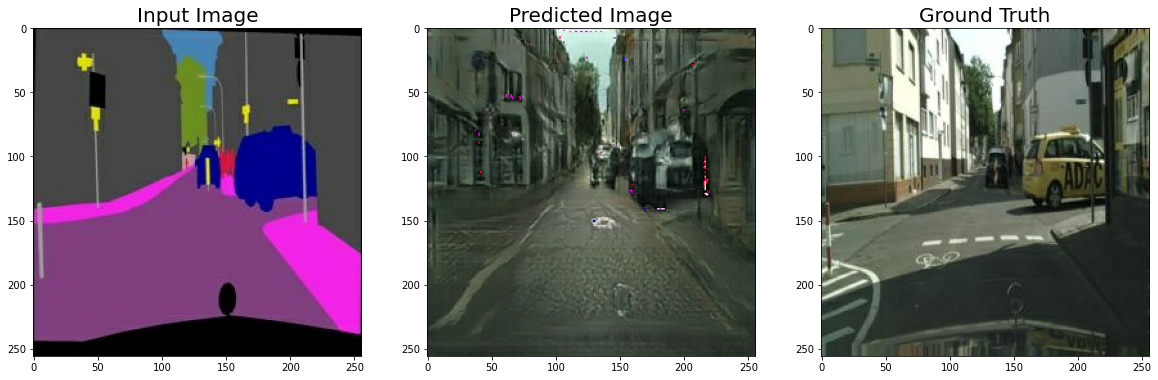

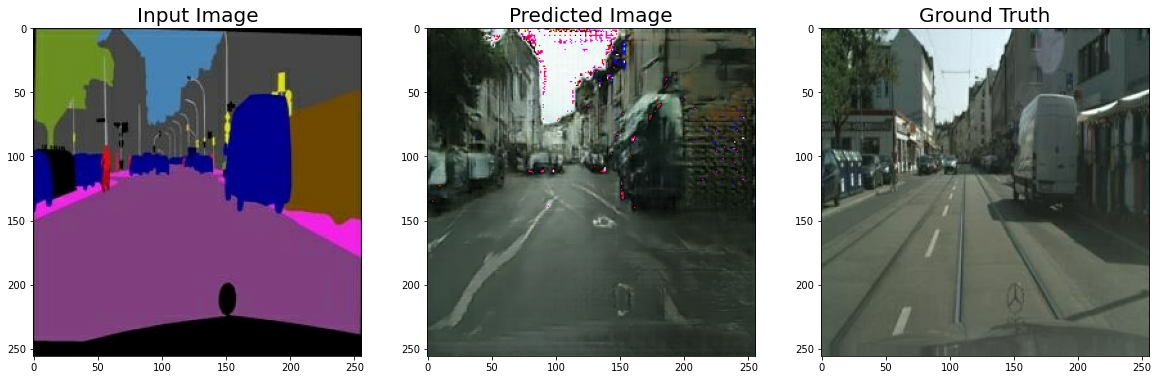

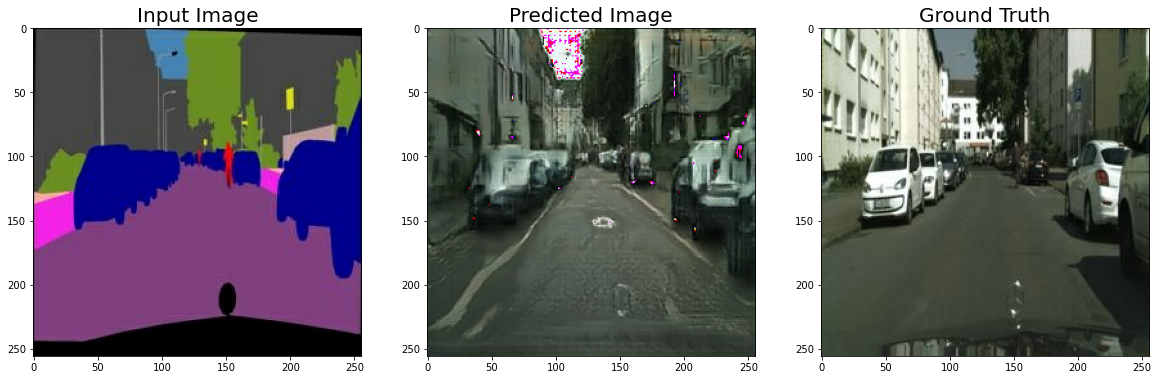

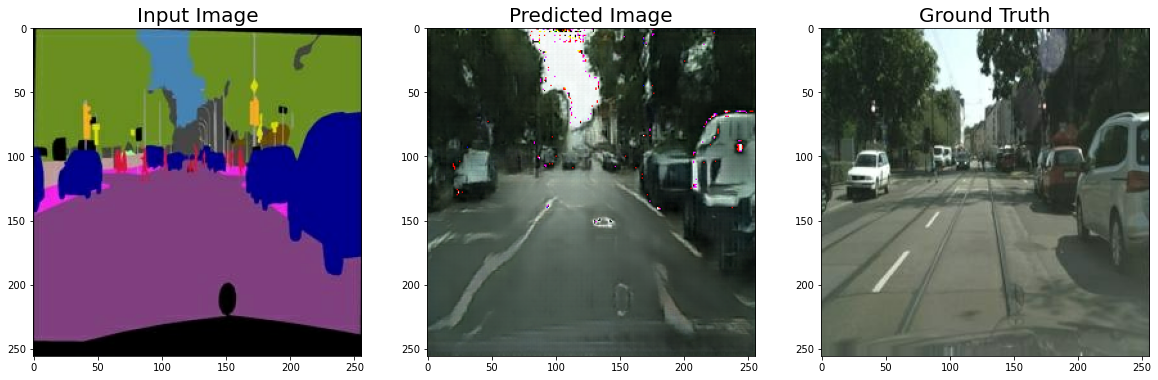

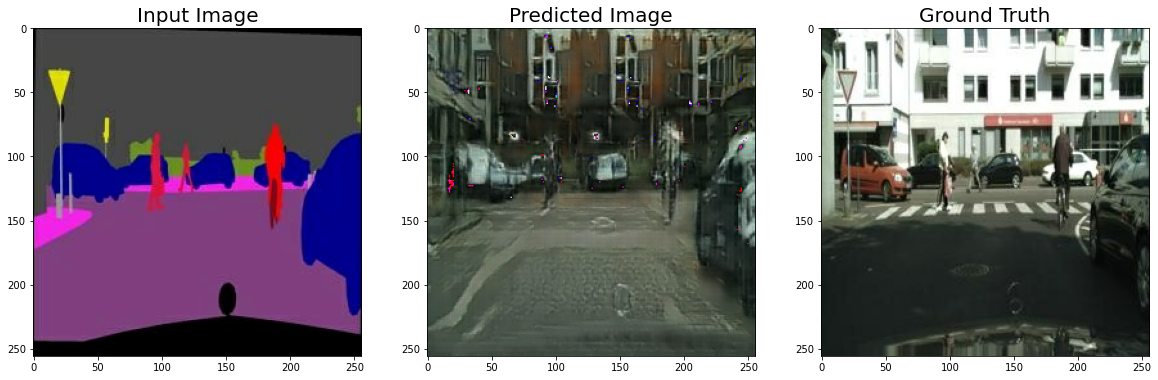

In [70]:
val_path = os.getenv('HOME')+'/aiffel/EXPLORATION/19/conditional_generation/cityscapes/val/'

for i in range(5):
    f = val_path + os.listdir(val_path)[i]
    input_image, real_image = load_img(f)

    pred = generator(tf.expand_dims(input_image, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(input_image)); plt.title('Input Image', fontsize=20)
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=20)
    plt.subplot(1,3,3); plt.imshow(denormalize(real_image)); plt.title('Ground Truth', fontsize=20)

### 회고

epoch을 많이 시도할수록..결과값이 좋아지는것 같다. 시간이 허락된다면 여러번 돌려보는게 좋을것 같다. 이전에는 이미즈를 입력해서 Segmentation map을 생성하는작업을 햇엇는데... 반대의 경우도 가능함을 확인했다. 그렇다면 반대의 경우는 어떤때에 필요할까? 일반적으로는 일반 이미지를 가지고 라벨링이나 세그멘테이션을 해서 그 이미지안에 어떤 것이 있는지 찾아내는 작업이 필요하다고 생각하였는데... 반대의 경우가 필요한 경우도 있나보다.. 뭐지? 뭐에 쓰이는걸까? 
우리가 가끔 접하는 과저의 흑백사진이나 영상자료를 컬러이미지로 변환하는데 사용되는건가? 싶다... 
마지막 EXPLORATION 끝!!!!